In [17]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt
from sklearn.impute import KNNImputer

In [9]:
# Fetching data

df = pd.read_csv('../data/dataset.csv')

<AxesSubplot:xlabel='Time'>

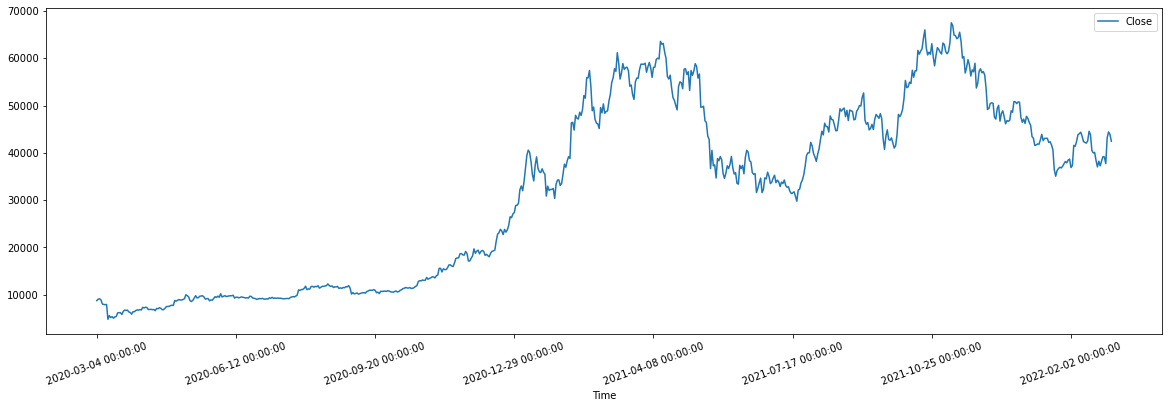

In [10]:
# Plotting btc prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

In [11]:
#Set Target Variable
output_var = pd.DataFrame(df["Close"])
#Selecting the Features
features = ["Compound", "Volume", "FundingRate", "Bitcoin_SVI", "Cryptocurrency_SVI", \
           "No. of Active Addresses", "No. of Unique Addresses", "Transactions"]

## Feature Scaling

In [12]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Compound,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,0.6616,0.006956,0.406593,0.070506,0.040714,0.399875,0.429122,0.844827
1,0.6616,0.010453,0.428571,0.076814,0.034898,0.324190,0.392319,0.811569
2,0.6616,0.003008,0.439560,0.073660,0.030586,0.338011,0.388311,0.771346
3,0.6616,0.001482,0.494505,0.054838,0.027677,0.193585,0.257815,0.680871
4,0.6616,0.009495,0.516484,0.064198,0.040714,0.161141,0.213671,0.642553


In [13]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set

In [15]:
num_cv = int(cv_size*len(feature_transform))
num_test = int(test_size*len(feature_transform))
num_train = len(feature_transform) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
X_train, y_train = feature_transform[:num_train], output_var[:num_train].values.ravel()
X_cv, y_cv = feature_transform[num_train:num_train+num_cv], output_var[num_train:num_train+num_cv].values.ravel()
X_train_cv, y_train_cv = feature_transform[:num_train+num_cv], output_var[:num_train+num_cv].values.ravel()
X_test, y_test = feature_transform[num_train+num_cv:], output_var[num_train+num_cv:].values.ravel()
print("train.shape = " + str(X_train.shape))
print("cv.shape = " + str(X_cv.shape))
print("train_cv.shape = " + str(X_train_cv.shape))
print("test.shape = " + str(X_test.shape))

num_train = 438
num_cv = 146
num_test = 146
train.shape = (438, 8)
cv.shape = (146, 8)
train_cv.shape = (584, 8)
test.shape = (146, 8)


In [16]:
print(X_train.isna().sum())
print(X_cv.isna().sum())
print(X_train_cv.isna().sum())
print(X_test.isna().sum())

Compound                   0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    2
Transactions               0
dtype: int64
Compound                   0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
dtype: int64
Compound                   0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    2
Transactions               0
dtype: int64
Compound                   0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
dtype: int64


In [18]:
KNN_miss_filling = KNNImputer(n_neighbors=2).fit(X_train)
X_train = pd.DataFrame(KNN_miss_filling.transform(X_train))

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(X_train_cv)
X_train_cv = pd.DataFrame(KNN_miss_filling.transform(X_train_cv))

In [19]:
print(X_train.isna().sum())
print(X_cv.isna().sum())
print(X_train_cv.isna().sum())
print(X_test.isna().sum())

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Compound                   0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
dtype: int64
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Compound                   0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
dtype: int64


In [66]:
def run(batchSize, numEpochs, X, Y, pred_set, actual_set):
    #Reshaping
    trainX =np.array(X)
    X = trainX.reshape(X.shape[0], 1, X.shape[1])
    
    testX =np.array(pred_set)
    pred_set = testX.reshape(pred_set.shape[0], 1, pred_set.shape[1])
    
    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss="mean_squared_error", optimizer="adam")
    plot_model(lstm, show_shapes=True, show_layer_names=True)

    ##################################################
    
    # Fitting the RNN to the Training set
    history = lstm.fit(X, Y, epochs=numEpochs, batch_size=batchSize, verbose=1, shuffle=False)
    predicted_Price = lstm.predict(pred_set)

    orig = actual_set

    rmse = sqrt(mean_squared_error(orig, predicted_Price))
    mape = get_mape(orig, predicted_Price)
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [25]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Param

In [86]:
# vary training batches
param_label = 'epochs'
param_list = [500, 1000, 1500, 2000, 2500, 3000]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(1, param, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/500
438/438 [==============================] - 1s 1ms/step - loss: 871746304.0000
Epoch 2/500
438/438 [==============================] - 0s 1ms/step - loss: 869042880.0000
Epoch 3/500
438/438 [==============================] - 0s 984us/step - loss: 865441536.0000
Epoch 4/500
438/438 [==============================] - 0s 1ms/step - loss: 860942016.0000
Epoch 5/500
438/438 [==============================] - 0s 984us/step - loss: 855584448.0000
Epoch 6/500
438/438 [==============================] - 0s 993us/step - loss: 849445568.0000
Epoch 7/500
438/438 [==============================] - 0s 1ms/step - loss: 842596032.0000
Epoch 8/500
438/438 [==============================] - 0s 916us/step - loss: 835097280.0000
Epoch 9/500
438/438 [==============================] - 0s 959us/step - loss: 827002368.0000
Epoch 10/500
438/4

Epoch 88/500
438/438 [==============================] - 0s 916us/step - loss: 97625792.0000
Epoch 89/500
438/438 [==============================] - 0s 930us/step - loss: 93549592.0000
Epoch 90/500
438/438 [==============================] - 0s 906us/step - loss: 89678560.0000
Epoch 91/500
438/438 [==============================] - 0s 916us/step - loss: 86009824.0000
Epoch 92/500
438/438 [==============================] - 0s 927us/step - loss: 82539816.0000
Epoch 93/500
438/438 [==============================] - 0s 901us/step - loss: 79264608.0000
Epoch 94/500
438/438 [==============================] - 0s 993us/step - loss: 76179656.0000
Epoch 95/500
438/438 [==============================] - 0s 914us/step - loss: 73279872.0000
Epoch 96/500
438/438 [==============================] - 0s 916us/step - loss: 70559848.0000
Epoch 97/500
438/438 [==============================] - 0s 934us/step - loss: 68013504.0000
Epoch 98/500
438/438 [==============================] - 0s 914us/step - loss: 65

438/438 [==============================] - 0s 890us/step - loss: 26237860.0000
Epoch 265/500
438/438 [==============================] - 0s 897us/step - loss: 26194636.0000
Epoch 266/500
438/438 [==============================] - 0s 888us/step - loss: 26151576.0000
Epoch 267/500
438/438 [==============================] - 0s 888us/step - loss: 26108702.0000
Epoch 268/500
438/438 [==============================] - 0s 893us/step - loss: 26065938.0000
Epoch 269/500
438/438 [==============================] - 0s 888us/step - loss: 26023386.0000
Epoch 270/500
438/438 [==============================] - 0s 885us/step - loss: 25980980.0000
Epoch 271/500
438/438 [==============================] - 0s 889us/step - loss: 25938740.0000
Epoch 272/500
438/438 [==============================] - 0s 886us/step - loss: 25896654.0000
Epoch 273/500
438/438 [==============================] - 0s 885us/step - loss: 25854730.0000
Epoch 274/500
438/438 [==============================] - 0s 893us/step - loss: 25812

438/438 [==============================] - 0s 892us/step - loss: 20919796.0000
Epoch 441/500
438/438 [==============================] - 0s 901us/step - loss: 20900528.0000
Epoch 442/500
438/438 [==============================] - 0s 888us/step - loss: 20881350.0000
Epoch 443/500
438/438 [==============================] - 0s 888us/step - loss: 20862228.0000
Epoch 444/500
438/438 [==============================] - 0s 914us/step - loss: 20843218.0000
Epoch 445/500
438/438 [==============================] - 0s 890us/step - loss: 20824274.0000
Epoch 446/500
438/438 [==============================] - 0s 886us/step - loss: 20805400.0000
Epoch 447/500
438/438 [==============================] - 0s 891us/step - loss: 20786614.0000
Epoch 448/500
438/438 [==============================] - 0s 889us/step - loss: 20767920.0000
Epoch 449/500
438/438 [==============================] - 0s 884us/step - loss: 20749280.0000
Epoch 450/500
438/438 [==============================] - 0s 893us/step - loss: 20730

438/438 [==============================] - 0s 903us/step - loss: 40423652.0000
Epoch 113/1000
438/438 [==============================] - 0s 901us/step - loss: 39869092.0000
Epoch 114/1000
438/438 [==============================] - 0s 926us/step - loss: 39350872.0000
Epoch 115/1000
438/438 [==============================] - 0s 909us/step - loss: 38868384.0000
Epoch 116/1000
438/438 [==============================] - 0s 904us/step - loss: 38420372.0000
Epoch 117/1000
438/438 [==============================] - 0s 904us/step - loss: 38005044.0000
Epoch 118/1000
438/438 [==============================] - 0s 902us/step - loss: 37620260.0000
Epoch 119/1000
438/438 [==============================] - 0s 922us/step - loss: 37263836.0000
Epoch 120/1000
438/438 [==============================] - 0s 914us/step - loss: 36933492.0000
Epoch 121/1000
438/438 [==============================] - 0s 914us/step - loss: 36627032.0000
Epoch 122/1000
438/438 [==============================] - 0s 909us/step - l

438/438 [==============================] - 0s 897us/step - loss: 25053434.0000
Epoch 287/1000
438/438 [==============================] - 0s 902us/step - loss: 25014268.0000
Epoch 288/1000
438/438 [==============================] - 0s 902us/step - loss: 24975264.0000
Epoch 289/1000
438/438 [==============================] - 0s 894us/step - loss: 24936434.0000
Epoch 290/1000
438/438 [==============================] - 0s 903us/step - loss: 24897810.0000
Epoch 291/1000
438/438 [==============================] - 0s 905us/step - loss: 24859362.0000
Epoch 292/1000
438/438 [==============================] - 0s 901us/step - loss: 24821100.0000
Epoch 293/1000
438/438 [==============================] - 0s 898us/step - loss: 24783026.0000
Epoch 294/1000
438/438 [==============================] - 0s 913us/step - loss: 24745112.0000
Epoch 295/1000
438/438 [==============================] - 0s 908us/step - loss: 24707388.0000
Epoch 296/1000
438/438 [==============================] - 0s 910us/step - l

438/438 [==============================] - 0s 893us/step - loss: 20505770.0000
Epoch 461/1000
438/438 [==============================] - 0s 910us/step - loss: 20488488.0000
Epoch 462/1000
438/438 [==============================] - 0s 905us/step - loss: 20471258.0000
Epoch 463/1000
438/438 [==============================] - 0s 901us/step - loss: 20454122.0000
Epoch 464/1000
438/438 [==============================] - 0s 916us/step - loss: 20437034.0000
Epoch 465/1000
438/438 [==============================] - 0s 903us/step - loss: 20420026.0000
Epoch 466/1000
438/438 [==============================] - 0s 901us/step - loss: 20403086.0000
Epoch 467/1000
438/438 [==============================] - 0s 915us/step - loss: 20386210.0000
Epoch 468/1000
438/438 [==============================] - 0s 908us/step - loss: 20369412.0000
Epoch 469/1000
438/438 [==============================] - 0s 899us/step - loss: 20352668.0000
Epoch 470/1000
438/438 [==============================] - 0s 910us/step - l

438/438 [==============================] - 0s 911us/step - loss: 18268118.0000
Epoch 635/1000
438/438 [==============================] - 0s 903us/step - loss: 18258538.0000
Epoch 636/1000
438/438 [==============================] - 0s 905us/step - loss: 18248980.0000
Epoch 637/1000
438/438 [==============================] - 0s 909us/step - loss: 18239448.0000
Epoch 638/1000
438/438 [==============================] - 0s 911us/step - loss: 18229944.0000
Epoch 639/1000
438/438 [==============================] - 0s 909us/step - loss: 18220466.0000
Epoch 640/1000
438/438 [==============================] - 0s 898us/step - loss: 18211014.0000
Epoch 641/1000
438/438 [==============================] - 0s 903us/step - loss: 18201570.0000
Epoch 642/1000
438/438 [==============================] - 0s 905us/step - loss: 18192168.0000
Epoch 643/1000
438/438 [==============================] - 0s 907us/step - loss: 18182778.0000
Epoch 644/1000
438/438 [==============================] - 0s 899us/step - l

438/438 [==============================] - 0s 906us/step - loss: 16878714.0000
Epoch 809/1000
438/438 [==============================] - 0s 909us/step - loss: 16871878.0000
Epoch 810/1000
438/438 [==============================] - 0s 910us/step - loss: 16865048.0000
Epoch 811/1000
438/438 [==============================] - 0s 905us/step - loss: 16858242.0000
Epoch 812/1000
438/438 [==============================] - 0s 991us/step - loss: 16851418.0000
Epoch 813/1000
438/438 [==============================] - 0s 893us/step - loss: 16844620.0000
Epoch 814/1000
438/438 [==============================] - 0s 903us/step - loss: 16837820.0000
Epoch 815/1000
438/438 [==============================] - 0s 908us/step - loss: 16831044.0000
Epoch 816/1000
438/438 [==============================] - 0s 922us/step - loss: 16824262.0000
Epoch 817/1000
438/438 [==============================] - 0s 894us/step - loss: 16817490.0000
Epoch 818/1000
438/438 [==============================] - 0s 918us/step - l

438/438 [==============================] - 0s 937us/step - loss: 15760460.0000
Epoch 983/1000
438/438 [==============================] - 0s 892us/step - loss: 15754438.0000
Epoch 984/1000
438/438 [==============================] - 0s 956us/step - loss: 15748424.0000
Epoch 985/1000
438/438 [==============================] - 0s 969us/step - loss: 15742409.0000
Epoch 986/1000
438/438 [==============================] - 0s 964us/step - loss: 15736412.0000
Epoch 987/1000
438/438 [==============================] - 0s 989us/step - loss: 15730419.0000
Epoch 988/1000
438/438 [==============================] - 0s 938us/step - loss: 15724432.0000
Epoch 989/1000
438/438 [==============================] - 0s 917us/step - loss: 15718448.0000
Epoch 990/1000
438/438 [==============================] - 0s 887us/step - loss: 15712471.0000
Epoch 991/1000
438/438 [==============================] - 0s 906us/step - loss: 15706502.0000
Epoch 992/1000
438/438 [==============================] - 0s 915us/step - l

438/438 [==============================] - 0s 920us/step - loss: 318944448.0000
Epoch 68/1500
438/438 [==============================] - 0s 920us/step - loss: 313837952.0000
Epoch 69/1500
438/438 [==============================] - 0s 941us/step - loss: 308950592.0000
Epoch 70/1500
438/438 [==============================] - 0s 940us/step - loss: 304235296.0000
Epoch 71/1500
438/438 [==============================] - 0s 916us/step - loss: 299493280.0000
Epoch 72/1500
438/438 [==============================] - 0s 911us/step - loss: 293975136.0000
Epoch 73/1500
438/438 [==============================] - 0s 906us/step - loss: 286961280.0000
Epoch 74/1500
438/438 [==============================] - 0s 914us/step - loss: 279340832.0000
Epoch 75/1500
438/438 [==============================] - 0s 916us/step - loss: 271857408.0000
Epoch 76/1500
438/438 [==============================] - 0s 912us/step - loss: 264571120.0000
Epoch 77/1500
438/438 [==============================] - 0s 917us/step - l

438/438 [==============================] - 0s 1ms/step - loss: 28120036.0000
Epoch 242/1500
438/438 [==============================] - 0s 895us/step - loss: 28070798.0000
Epoch 243/1500
438/438 [==============================] - 0s 888us/step - loss: 28021792.0000
Epoch 244/1500
438/438 [==============================] - 0s 889us/step - loss: 27973028.0000
Epoch 245/1500
438/438 [==============================] - 0s 879us/step - loss: 27924488.0000
Epoch 246/1500
438/438 [==============================] - 0s 898us/step - loss: 27876168.0000
Epoch 247/1500
438/438 [==============================] - 0s 889us/step - loss: 27828056.0000
Epoch 248/1500
438/438 [==============================] - 0s 887us/step - loss: 27780174.0000
Epoch 249/1500
438/438 [==============================] - 0s 905us/step - loss: 27732488.0000
Epoch 250/1500
438/438 [==============================] - 0s 888us/step - loss: 27685014.0000
Epoch 251/1500
438/438 [==============================] - 0s 884us/step - los

438/438 [==============================] - 0s 860us/step - loss: 22012770.0000
Epoch 416/1500
438/438 [==============================] - 0s 870us/step - loss: 21990912.0000
Epoch 417/1500
438/438 [==============================] - 0s 862us/step - loss: 21969176.0000
Epoch 418/1500
438/438 [==============================] - 0s 857us/step - loss: 21947556.0000
Epoch 419/1500
438/438 [==============================] - 0s 857us/step - loss: 21926036.0000
Epoch 420/1500
438/438 [==============================] - 0s 870us/step - loss: 21904664.0000
Epoch 421/1500
438/438 [==============================] - 0s 862us/step - loss: 21883402.0000
Epoch 422/1500
438/438 [==============================] - 0s 859us/step - loss: 21862206.0000
Epoch 423/1500
438/438 [==============================] - 0s 863us/step - loss: 21841144.0000
Epoch 424/1500
438/438 [==============================] - 0s 862us/step - loss: 21820176.0000
Epoch 425/1500
438/438 [==============================] - 0s 859us/step - l

438/438 [==============================] - 0s 867us/step - loss: 19183118.0000
Epoch 590/1500
438/438 [==============================] - 0s 860us/step - loss: 19171762.0000
Epoch 591/1500
438/438 [==============================] - 0s 869us/step - loss: 19160434.0000
Epoch 592/1500
438/438 [==============================] - 0s 866us/step - loss: 19149138.0000
Epoch 593/1500
438/438 [==============================] - 0s 859us/step - loss: 19137890.0000
Epoch 594/1500
438/438 [==============================] - 0s 859us/step - loss: 19126666.0000
Epoch 595/1500
438/438 [==============================] - 0s 860us/step - loss: 19115488.0000
Epoch 596/1500
438/438 [==============================] - 0s 860us/step - loss: 19104340.0000
Epoch 597/1500
438/438 [==============================] - 0s 858us/step - loss: 19093228.0000
Epoch 598/1500
438/438 [==============================] - 0s 858us/step - loss: 19082144.0000
Epoch 599/1500
438/438 [==============================] - 0s 859us/step - l

438/438 [==============================] - 0s 879us/step - loss: 17556692.0000
Epoch 764/1500
438/438 [==============================] - 0s 883us/step - loss: 17548694.0000
Epoch 765/1500
438/438 [==============================] - 0s 868us/step - loss: 17540688.0000
Epoch 766/1500
438/438 [==============================] - 0s 856us/step - loss: 17532698.0000
Epoch 767/1500
438/438 [==============================] - 0s 855us/step - loss: 17524704.0000
Epoch 768/1500
438/438 [==============================] - 0s 857us/step - loss: 17516718.0000
Epoch 769/1500
438/438 [==============================] - 0s 854us/step - loss: 17508742.0000
Epoch 770/1500
438/438 [==============================] - 0s 854us/step - loss: 17500760.0000
Epoch 771/1500
438/438 [==============================] - 0s 857us/step - loss: 17492786.0000
Epoch 772/1500
438/438 [==============================] - 0s 861us/step - loss: 17484816.0000
Epoch 773/1500
438/438 [==============================] - 0s 882us/step - l

438/438 [==============================] - 0s 865us/step - loss: 16227430.0000
Epoch 938/1500
438/438 [==============================] - 0s 862us/step - loss: 16220658.0000
Epoch 939/1500
438/438 [==============================] - 0s 859us/step - loss: 16213891.0000
Epoch 940/1500
438/438 [==============================] - 0s 859us/step - loss: 16207140.0000
Epoch 941/1500
438/438 [==============================] - 0s 860us/step - loss: 16200406.0000
Epoch 942/1500
438/438 [==============================] - 0s 858us/step - loss: 16193675.0000
Epoch 943/1500
438/438 [==============================] - 0s 858us/step - loss: 16186954.0000
Epoch 944/1500
438/438 [==============================] - 0s 858us/step - loss: 16180253.0000
Epoch 945/1500
438/438 [==============================] - 0s 861us/step - loss: 16173553.0000
Epoch 946/1500
438/438 [==============================] - 0s 861us/step - loss: 16166866.0000
Epoch 947/1500
438/438 [==============================] - 0s 860us/step - l

438/438 [==============================] - 0s 856us/step - loss: 15671972.0000
Epoch 1025/1500
438/438 [==============================] - 0s 856us/step - loss: 15665878.0000
Epoch 1026/1500
438/438 [==============================] - 0s 972us/step - loss: 15659777.0000
Epoch 1027/1500
438/438 [==============================] - 0s 933us/step - loss: 15653665.0000
Epoch 1028/1500
438/438 [==============================] - 0s 897us/step - loss: 15647583.0000
Epoch 1029/1500
438/438 [==============================] - 0s 889us/step - loss: 15641485.0000
Epoch 1030/1500
438/438 [==============================] - 0s 928us/step - loss: 15635401.0000
Epoch 1031/1500
438/438 [==============================] - 0s 865us/step - loss: 15629321.0000
Epoch 1032/1500
438/438 [==============================] - 0s 860us/step - loss: 15623222.0000
Epoch 1033/1500
438/438 [==============================] - 0s 863us/step - loss: 15617151.0000
Epoch 1034/1500
438/438 [==============================] - 0s 860u

438/438 [==============================] - 0s 856us/step - loss: 14532018.0000
Epoch 1197/1500
438/438 [==============================] - 0s 857us/step - loss: 14524145.0000
Epoch 1198/1500
438/438 [==============================] - 0s 854us/step - loss: 14516263.0000
Epoch 1199/1500
438/438 [==============================] - 0s 856us/step - loss: 14508365.0000
Epoch 1200/1500
438/438 [==============================] - 0s 854us/step - loss: 14500450.0000
Epoch 1201/1500
438/438 [==============================] - 0s 857us/step - loss: 14492533.0000
Epoch 1202/1500
438/438 [==============================] - 0s 855us/step - loss: 14484589.0000
Epoch 1203/1500
438/438 [==============================] - 0s 855us/step - loss: 14476633.0000
Epoch 1204/1500
438/438 [==============================] - 0s 854us/step - loss: 14468663.0000
Epoch 1205/1500
438/438 [==============================] - 0s 856us/step - loss: 14460685.0000
Epoch 1206/1500
438/438 [==============================] - 0s 858u

438/438 [==============================] - 0s 854us/step - loss: 13111878.0000
Epoch 1369/1500
438/438 [==============================] - 0s 856us/step - loss: 13104070.0000
Epoch 1370/1500
438/438 [==============================] - 0s 855us/step - loss: 13096273.0000
Epoch 1371/1500
438/438 [==============================] - 0s 858us/step - loss: 13088496.0000
Epoch 1372/1500
438/438 [==============================] - 0s 854us/step - loss: 13080741.0000
Epoch 1373/1500
438/438 [==============================] - 0s 852us/step - loss: 13072986.0000
Epoch 1374/1500
438/438 [==============================] - 0s 854us/step - loss: 13065262.0000
Epoch 1375/1500
438/438 [==============================] - 0s 853us/step - loss: 13057538.0000
Epoch 1376/1500
438/438 [==============================] - 0s 855us/step - loss: 13049838.0000
Epoch 1377/1500
438/438 [==============================] - 0s 860us/step - loss: 13042148.0000
Epoch 1378/1500
438/438 [==============================] - 0s 871u

438/438 [==============================] - 0s 857us/step - loss: 440603104.0000
Epoch 39/2000
438/438 [==============================] - 0s 853us/step - loss: 428784544.0000
Epoch 40/2000
438/438 [==============================] - 0s 872us/step - loss: 417329920.0000
Epoch 41/2000
438/438 [==============================] - 0s 855us/step - loss: 406254752.0000
Epoch 42/2000
438/438 [==============================] - 0s 854us/step - loss: 395572288.0000
Epoch 43/2000
438/438 [==============================] - 0s 857us/step - loss: 385293664.0000
Epoch 44/2000
438/438 [==============================] - 0s 859us/step - loss: 375427488.0000
Epoch 45/2000
438/438 [==============================] - 0s 863us/step - loss: 365980256.0000
Epoch 46/2000
438/438 [==============================] - 0s 859us/step - loss: 356956256.0000
Epoch 47/2000
438/438 [==============================] - 0s 865us/step - loss: 348357696.0000
Epoch 48/2000
438/438 [==============================] - 0s 857us/step - l

438/438 [==============================] - 0s 945us/step - loss: 28331892.0000
Epoch 213/2000
438/438 [==============================] - 0s 880us/step - loss: 28279282.0000
Epoch 214/2000
438/438 [==============================] - 0s 900us/step - loss: 28226898.0000
Epoch 215/2000
438/438 [==============================] - 0s 879us/step - loss: 28174764.0000
Epoch 216/2000
438/438 [==============================] - 0s 881us/step - loss: 28122878.0000
Epoch 217/2000
438/438 [==============================] - 0s 864us/step - loss: 28071226.0000
Epoch 218/2000
438/438 [==============================] - 0s 854us/step - loss: 28019800.0000
Epoch 219/2000
438/438 [==============================] - 0s 862us/step - loss: 27968618.0000
Epoch 220/2000
438/438 [==============================] - 0s 856us/step - loss: 27917660.0000
Epoch 221/2000
438/438 [==============================] - 0s 853us/step - loss: 27866930.0000
Epoch 222/2000
438/438 [==============================] - 0s 868us/step - l

438/438 [==============================] - 0s 852us/step - loss: 21869030.0000
Epoch 387/2000
438/438 [==============================] - 0s 851us/step - loss: 21845334.0000
Epoch 388/2000
438/438 [==============================] - 0s 857us/step - loss: 21821740.0000
Epoch 389/2000
438/438 [==============================] - 0s 849us/step - loss: 21798286.0000
Epoch 390/2000
438/438 [==============================] - 0s 851us/step - loss: 21774926.0000
Epoch 391/2000
438/438 [==============================] - 0s 853us/step - loss: 21751698.0000
Epoch 392/2000
438/438 [==============================] - 0s 853us/step - loss: 21728566.0000
Epoch 393/2000
438/438 [==============================] - 0s 854us/step - loss: 21705558.0000
Epoch 394/2000
438/438 [==============================] - 0s 853us/step - loss: 21682658.0000
Epoch 395/2000
438/438 [==============================] - 0s 851us/step - loss: 21659874.0000
Epoch 396/2000
438/438 [==============================] - 0s 851us/step - l

438/438 [==============================] - 0s 857us/step - loss: 18920128.0000
Epoch 561/2000
438/438 [==============================] - 0s 858us/step - loss: 18908926.0000
Epoch 562/2000
438/438 [==============================] - 0s 858us/step - loss: 18897776.0000
Epoch 563/2000
438/438 [==============================] - 0s 868us/step - loss: 18886666.0000
Epoch 564/2000
438/438 [==============================] - 0s 873us/step - loss: 18875604.0000
Epoch 565/2000
438/438 [==============================] - 0s 888us/step - loss: 18864590.0000
Epoch 566/2000
438/438 [==============================] - 0s 899us/step - loss: 18853622.0000
Epoch 567/2000
438/438 [==============================] - 0s 905us/step - loss: 18842696.0000
Epoch 568/2000
438/438 [==============================] - 0s 877us/step - loss: 18831820.0000
Epoch 569/2000
438/438 [==============================] - 0s 876us/step - loss: 18820980.0000
Epoch 570/2000
438/438 [==============================] - 0s 882us/step - l

438/438 [==============================] - 0s 854us/step - loss: 17439436.0000
Epoch 735/2000
438/438 [==============================] - 0s 869us/step - loss: 17432712.0000
Epoch 736/2000
438/438 [==============================] - 0s 852us/step - loss: 17426000.0000
Epoch 737/2000
438/438 [==============================] - 0s 852us/step - loss: 17419296.0000
Epoch 738/2000
438/438 [==============================] - 0s 849us/step - loss: 17412612.0000
Epoch 739/2000
438/438 [==============================] - 0s 852us/step - loss: 17405928.0000
Epoch 740/2000
438/438 [==============================] - 0s 869us/step - loss: 17399278.0000
Epoch 741/2000
438/438 [==============================] - 0s 851us/step - loss: 17392628.0000
Epoch 742/2000
438/438 [==============================] - 0s 849us/step - loss: 17385984.0000
Epoch 743/2000
438/438 [==============================] - 0s 851us/step - loss: 17379360.0000
Epoch 744/2000
438/438 [==============================] - 0s 848us/step - l

438/438 [==============================] - 0s 881us/step - loss: 16411798.0000
Epoch 909/2000
438/438 [==============================] - 0s 853us/step - loss: 16406482.0000
Epoch 910/2000
438/438 [==============================] - 0s 853us/step - loss: 16401182.0000
Epoch 911/2000
438/438 [==============================] - 0s 852us/step - loss: 16395885.0000
Epoch 912/2000
438/438 [==============================] - 0s 848us/step - loss: 16390601.0000
Epoch 913/2000
438/438 [==============================] - 0s 859us/step - loss: 16385313.0000
Epoch 914/2000
438/438 [==============================] - 0s 848us/step - loss: 16380029.0000
Epoch 915/2000
438/438 [==============================] - 0s 848us/step - loss: 16374758.0000
Epoch 916/2000
438/438 [==============================] - 0s 848us/step - loss: 16369485.0000
Epoch 917/2000
438/438 [==============================] - 0s 849us/step - loss: 16364216.0000
Epoch 918/2000
438/438 [==============================] - 0s 851us/step - l

438/438 [==============================] - 0s 856us/step - loss: 15545682.0000
Epoch 1082/2000
438/438 [==============================] - 0s 848us/step - loss: 15540839.0000
Epoch 1083/2000
438/438 [==============================] - 0s 854us/step - loss: 15535989.0000
Epoch 1084/2000
438/438 [==============================] - 0s 853us/step - loss: 15531151.0000
Epoch 1085/2000
438/438 [==============================] - 0s 855us/step - loss: 15526301.0000
Epoch 1086/2000
438/438 [==============================] - 0s 850us/step - loss: 15521465.0000
Epoch 1087/2000
438/438 [==============================] - 0s 847us/step - loss: 15516622.0000
Epoch 1088/2000
438/438 [==============================] - 0s 854us/step - loss: 15511772.0000
Epoch 1089/2000
438/438 [==============================] - 0s 850us/step - loss: 15506930.0000
Epoch 1090/2000
438/438 [==============================] - 0s 881us/step - loss: 15502082.0000
Epoch 1091/2000
438/438 [==============================] - 0s 849u

438/438 [==============================] - 0s 853us/step - loss: 14718851.0000
Epoch 1254/2000
438/438 [==============================] - 0s 853us/step - loss: 14714196.0000
Epoch 1255/2000
438/438 [==============================] - 0s 854us/step - loss: 14709544.0000
Epoch 1256/2000
438/438 [==============================] - 0s 860us/step - loss: 14704897.0000
Epoch 1257/2000
438/438 [==============================] - 0s 850us/step - loss: 14700249.0000
Epoch 1258/2000
438/438 [==============================] - 0s 851us/step - loss: 14695602.0000
Epoch 1259/2000
438/438 [==============================] - 0s 852us/step - loss: 14690953.0000
Epoch 1260/2000
438/438 [==============================] - 0s 881us/step - loss: 14686310.0000
Epoch 1261/2000
438/438 [==============================] - 0s 859us/step - loss: 14681671.0000
Epoch 1262/2000
438/438 [==============================] - 0s 854us/step - loss: 14677028.0000
Epoch 1263/2000
438/438 [==============================] - 0s 850u

438/438 [==============================] - 0s 872us/step - loss: 13939582.0000
Epoch 1426/2000
438/438 [==============================] - 0s 885us/step - loss: 13935195.0000
Epoch 1427/2000
438/438 [==============================] - 0s 944us/step - loss: 13930796.0000
Epoch 1428/2000
438/438 [==============================] - 0s 856us/step - loss: 13926411.0000
Epoch 1429/2000
438/438 [==============================] - 0s 856us/step - loss: 13922020.0000
Epoch 1430/2000
438/438 [==============================] - 0s 850us/step - loss: 13917635.0000
Epoch 1431/2000
438/438 [==============================] - 0s 882us/step - loss: 13913252.0000
Epoch 1432/2000
438/438 [==============================] - 0s 869us/step - loss: 13908852.0000
Epoch 1433/2000
438/438 [==============================] - 0s 851us/step - loss: 13904480.0000
Epoch 1434/2000
438/438 [==============================] - 0s 853us/step - loss: 13900097.0000
Epoch 1435/2000
438/438 [==============================] - 0s 851u

438/438 [==============================] - 0s 875us/step - loss: 13194965.0000
Epoch 1598/2000
438/438 [==============================] - 0s 873us/step - loss: 13190481.0000
Epoch 1599/2000
438/438 [==============================] - 0s 871us/step - loss: 13185977.0000
Epoch 1600/2000
438/438 [==============================] - 0s 873us/step - loss: 13181476.0000
Epoch 1601/2000
438/438 [==============================] - 0s 877us/step - loss: 13176966.0000
Epoch 1602/2000
438/438 [==============================] - 0s 874us/step - loss: 13172441.0000
Epoch 1603/2000
438/438 [==============================] - 0s 876us/step - loss: 13167907.0000
Epoch 1604/2000
438/438 [==============================] - 0s 872us/step - loss: 13163366.0000
Epoch 1605/2000
438/438 [==============================] - 0s 873us/step - loss: 13158818.0000
Epoch 1606/2000
438/438 [==============================] - 0s 874us/step - loss: 13154260.0000
Epoch 1607/2000
438/438 [==============================] - 0s 901u

438/438 [==============================] - 0s 853us/step - loss: 12176373.0000
Epoch 1770/2000
438/438 [==============================] - 0s 850us/step - loss: 12169466.0000
Epoch 1771/2000
438/438 [==============================] - 0s 853us/step - loss: 12162559.0000
Epoch 1772/2000
438/438 [==============================] - 0s 851us/step - loss: 12155641.0000
Epoch 1773/2000
438/438 [==============================] - 0s 856us/step - loss: 12148723.0000
Epoch 1774/2000
438/438 [==============================] - 0s 854us/step - loss: 12141811.0000
Epoch 1775/2000
438/438 [==============================] - 0s 865us/step - loss: 12134882.0000
Epoch 1776/2000
438/438 [==============================] - 0s 852us/step - loss: 12127961.0000
Epoch 1777/2000
438/438 [==============================] - 0s 854us/step - loss: 12121030.0000
Epoch 1778/2000
438/438 [==============================] - 0s 851us/step - loss: 12114099.0000
Epoch 1779/2000
438/438 [==============================] - 0s 859u

438/438 [==============================] - 0s 879us/step - loss: 10958556.0000
Epoch 1942/2000
438/438 [==============================] - 0s 875us/step - loss: 10951904.0000
Epoch 1943/2000
438/438 [==============================] - 0s 876us/step - loss: 10945275.0000
Epoch 1944/2000
438/438 [==============================] - 0s 877us/step - loss: 10938664.0000
Epoch 1945/2000
438/438 [==============================] - 0s 881us/step - loss: 10932081.0000
Epoch 1946/2000
438/438 [==============================] - 0s 879us/step - loss: 10925519.0000
Epoch 1947/2000
438/438 [==============================] - 0s 874us/step - loss: 10918973.0000
Epoch 1948/2000
438/438 [==============================] - 0s 905us/step - loss: 10912455.0000
Epoch 1949/2000
438/438 [==============================] - 0s 876us/step - loss: 10905958.0000
Epoch 1950/2000
438/438 [==============================] - 0s 876us/step - loss: 10899485.0000
Epoch 1951/2000
438/438 [==============================] - 0s 874u

438/438 [==============================] - 0s 885us/step - loss: 45762100.0000
Epoch 113/2500
438/438 [==============================] - 0s 882us/step - loss: 44932240.0000
Epoch 114/2500
438/438 [==============================] - 0s 879us/step - loss: 44140576.0000
Epoch 115/2500
438/438 [==============================] - 0s 878us/step - loss: 43382888.0000
Epoch 116/2500
438/438 [==============================] - 0s 878us/step - loss: 42657548.0000
Epoch 117/2500
438/438 [==============================] - 0s 886us/step - loss: 41965348.0000
Epoch 118/2500
438/438 [==============================] - 0s 879us/step - loss: 41308496.0000
Epoch 119/2500
438/438 [==============================] - 0s 881us/step - loss: 40689424.0000
Epoch 120/2500
438/438 [==============================] - 0s 881us/step - loss: 40109592.0000
Epoch 121/2500
438/438 [==============================] - 0s 880us/step - loss: 39569188.0000
Epoch 122/2500
438/438 [==============================] - 0s 881us/step - l

438/438 [==============================] - 0s 858us/step - loss: 25442294.0000
Epoch 287/2500
438/438 [==============================] - 0s 856us/step - loss: 25403782.0000
Epoch 288/2500
438/438 [==============================] - 0s 856us/step - loss: 25365438.0000
Epoch 289/2500
438/438 [==============================] - 0s 855us/step - loss: 25327296.0000
Epoch 290/2500
438/438 [==============================] - 0s 855us/step - loss: 25289310.0000
Epoch 291/2500
438/438 [==============================] - 0s 860us/step - loss: 25251518.0000
Epoch 292/2500
438/438 [==============================] - 0s 857us/step - loss: 25213896.0000
Epoch 293/2500
438/438 [==============================] - 0s 854us/step - loss: 25176446.0000
Epoch 294/2500
438/438 [==============================] - 0s 855us/step - loss: 25139182.0000
Epoch 295/2500
438/438 [==============================] - 0s 860us/step - loss: 25102072.0000
Epoch 296/2500
438/438 [==============================] - 0s 858us/step - l

438/438 [==============================] - 0s 879us/step - loss: 20775488.0000
Epoch 461/2500
438/438 [==============================] - 0s 884us/step - loss: 20756624.0000
Epoch 462/2500
438/438 [==============================] - 0s 893us/step - loss: 20737798.0000
Epoch 463/2500
438/438 [==============================] - 0s 879us/step - loss: 20719036.0000
Epoch 464/2500
438/438 [==============================] - 0s 880us/step - loss: 20700312.0000
Epoch 465/2500
438/438 [==============================] - 0s 882us/step - loss: 20681636.0000
Epoch 466/2500
438/438 [==============================] - 0s 877us/step - loss: 20663034.0000
Epoch 467/2500
438/438 [==============================] - 0s 881us/step - loss: 20644472.0000
Epoch 468/2500
438/438 [==============================] - 0s 879us/step - loss: 20625960.0000
Epoch 469/2500
438/438 [==============================] - 0s 881us/step - loss: 20607518.0000
Epoch 470/2500
438/438 [==============================] - 0s 880us/step - l

438/438 [==============================] - 0s 858us/step - loss: 18369526.0000
Epoch 635/2500
438/438 [==============================] - 0s 858us/step - loss: 18359766.0000
Epoch 636/2500
438/438 [==============================] - 0s 859us/step - loss: 18350018.0000
Epoch 637/2500
438/438 [==============================] - 0s 855us/step - loss: 18340314.0000
Epoch 638/2500
438/438 [==============================] - 0s 860us/step - loss: 18330636.0000
Epoch 639/2500
438/438 [==============================] - 0s 856us/step - loss: 18320992.0000
Epoch 640/2500
438/438 [==============================] - 0s 857us/step - loss: 18311382.0000
Epoch 641/2500
438/438 [==============================] - 0s 858us/step - loss: 18301808.0000
Epoch 642/2500
438/438 [==============================] - 0s 859us/step - loss: 18292260.0000
Epoch 643/2500
438/438 [==============================] - 0s 863us/step - loss: 18282744.0000
Epoch 644/2500
438/438 [==============================] - 0s 866us/step - l

438/438 [==============================] - 0s 878us/step - loss: 16986682.0000
Epoch 809/2500
438/438 [==============================] - 0s 882us/step - loss: 16979870.0000
Epoch 810/2500
438/438 [==============================] - 0s 880us/step - loss: 16973060.0000
Epoch 811/2500
438/438 [==============================] - 0s 877us/step - loss: 16966264.0000
Epoch 812/2500
438/438 [==============================] - 0s 881us/step - loss: 16959472.0000
Epoch 813/2500
438/438 [==============================] - 0s 878us/step - loss: 16952676.0000
Epoch 814/2500
438/438 [==============================] - 0s 880us/step - loss: 16945902.0000
Epoch 815/2500
438/438 [==============================] - 0s 875us/step - loss: 16939124.0000
Epoch 816/2500
438/438 [==============================] - 0s 876us/step - loss: 16932352.0000
Epoch 817/2500
438/438 [==============================] - 0s 878us/step - loss: 16925594.0000
Epoch 818/2500
438/438 [==============================] - 0s 877us/step - l

438/438 [==============================] - 0s 878us/step - loss: 15869048.0000
Epoch 983/2500
438/438 [==============================] - 0s 878us/step - loss: 15863105.0000
Epoch 984/2500
438/438 [==============================] - 0s 877us/step - loss: 15857172.0000
Epoch 985/2500
438/438 [==============================] - 0s 877us/step - loss: 15851253.0000
Epoch 986/2500
438/438 [==============================] - 0s 1ms/step - loss: 15845326.0000
Epoch 987/2500
438/438 [==============================] - 0s 881us/step - loss: 15839418.0000
Epoch 988/2500
438/438 [==============================] - 0s 875us/step - loss: 15833517.0000
Epoch 989/2500
438/438 [==============================] - 0s 879us/step - loss: 15827621.0000
Epoch 990/2500
438/438 [==============================] - 0s 897us/step - loss: 15821729.0000
Epoch 991/2500
438/438 [==============================] - 0s 891us/step - loss: 15815857.0000
Epoch 992/2500
438/438 [==============================] - 0s 878us/step - los

438/438 [==============================] - 0s 880us/step - loss: 14923055.0000
Epoch 1155/2500
438/438 [==============================] - 0s 879us/step - loss: 14917640.0000
Epoch 1156/2500
438/438 [==============================] - 0s 880us/step - loss: 14912229.0000
Epoch 1157/2500
438/438 [==============================] - 0s 886us/step - loss: 14906812.0000
Epoch 1158/2500
438/438 [==============================] - 0s 880us/step - loss: 14901394.0000
Epoch 1159/2500
438/438 [==============================] - 0s 879us/step - loss: 14895968.0000
Epoch 1160/2500
438/438 [==============================] - 0s 895us/step - loss: 14890532.0000
Epoch 1161/2500
438/438 [==============================] - 0s 892us/step - loss: 14885085.0000
Epoch 1162/2500
438/438 [==============================] - 0s 883us/step - loss: 14879647.0000
Epoch 1163/2500
438/438 [==============================] - 0s 886us/step - loss: 14874196.0000
Epoch 1164/2500
438/438 [==============================] - 0s 884u

438/438 [==============================] - 0s 869us/step - loss: 13853213.0000
Epoch 1327/2500
438/438 [==============================] - 0s 884us/step - loss: 13846466.0000
Epoch 1328/2500
438/438 [==============================] - 0s 915us/step - loss: 13839715.0000
Epoch 1329/2500
438/438 [==============================] - 0s 938us/step - loss: 13832967.0000
Epoch 1330/2500
438/438 [==============================] - 0s 884us/step - loss: 13826235.0000
Epoch 1331/2500
438/438 [==============================] - 0s 878us/step - loss: 13819507.0000
Epoch 1332/2500
438/438 [==============================] - 0s 915us/step - loss: 13812765.0000
Epoch 1333/2500
438/438 [==============================] - 0s 919us/step - loss: 13806024.0000
Epoch 1334/2500
438/438 [==============================] - 0s 884us/step - loss: 13799305.0000
Epoch 1335/2500
438/438 [==============================] - 0s 881us/step - loss: 13792575.0000
Epoch 1336/2500
438/438 [==============================] - 0s 896u

438/438 [==============================] - 0s 879us/step - loss: 12734348.0000
Epoch 1499/2500
438/438 [==============================] - 0s 879us/step - loss: 12728138.0000
Epoch 1500/2500
438/438 [==============================] - 0s 881us/step - loss: 12721922.0000
Epoch 1501/2500
438/438 [==============================] - 0s 916us/step - loss: 12715708.0000
Epoch 1502/2500
438/438 [==============================] - 0s 878us/step - loss: 12709506.0000
Epoch 1503/2500
438/438 [==============================] - 0s 875us/step - loss: 12703308.0000
Epoch 1504/2500
438/438 [==============================] - 0s 878us/step - loss: 12697101.0000
Epoch 1505/2500
438/438 [==============================] - 0s 876us/step - loss: 12690909.0000
Epoch 1506/2500
438/438 [==============================] - 0s 874us/step - loss: 12684715.0000
Epoch 1507/2500
438/438 [==============================] - 0s 877us/step - loss: 12678520.0000
Epoch 1508/2500
438/438 [==============================] - 0s 882u

438/438 [==============================] - 0s 876us/step - loss: 11657487.0000
Epoch 1671/2500
438/438 [==============================] - 0s 885us/step - loss: 11650934.0000
Epoch 1672/2500
438/438 [==============================] - 0s 881us/step - loss: 11644370.0000
Epoch 1673/2500
438/438 [==============================] - 0s 877us/step - loss: 11637821.0000
Epoch 1674/2500
438/438 [==============================] - 0s 875us/step - loss: 11631252.0000
Epoch 1675/2500
438/438 [==============================] - 0s 874us/step - loss: 11624692.0000
Epoch 1676/2500
438/438 [==============================] - 0s 888us/step - loss: 11618126.0000
Epoch 1677/2500
438/438 [==============================] - 0s 875us/step - loss: 11611563.0000
Epoch 1678/2500
438/438 [==============================] - 0s 879us/step - loss: 11604994.0000
Epoch 1679/2500
438/438 [==============================] - 0s 876us/step - loss: 11598417.0000
Epoch 1680/2500
438/438 [==============================] - 0s 876u

438/438 [==============================] - 0s 853us/step - loss: 10591870.0000
Epoch 1843/2500
438/438 [==============================] - 0s 851us/step - loss: 10586620.0000
Epoch 1844/2500
438/438 [==============================] - 0s 855us/step - loss: 10581384.0000
Epoch 1845/2500
438/438 [==============================] - 0s 852us/step - loss: 10576160.0000
Epoch 1846/2500
438/438 [==============================] - 0s 855us/step - loss: 10570948.0000
Epoch 1847/2500
438/438 [==============================] - 0s 852us/step - loss: 10565756.0000
Epoch 1848/2500
438/438 [==============================] - 0s 854us/step - loss: 10560568.0000
Epoch 1849/2500
438/438 [==============================] - 0s 854us/step - loss: 10555403.0000
Epoch 1850/2500
438/438 [==============================] - 0s 852us/step - loss: 10550254.0000
Epoch 1851/2500
438/438 [==============================] - 0s 854us/step - loss: 10545113.0000
Epoch 1852/2500
438/438 [==============================] - 0s 853u

438/438 [==============================] - 0s 875us/step - loss: 9862808.0000
Epoch 2015/2500
438/438 [==============================] - 0s 887us/step - loss: 9859361.0000
Epoch 2016/2500
438/438 [==============================] - 0s 879us/step - loss: 9855917.0000
Epoch 2017/2500
438/438 [==============================] - 0s 877us/step - loss: 9852485.0000
Epoch 2018/2500
438/438 [==============================] - 0s 881us/step - loss: 9849053.0000
Epoch 2019/2500
438/438 [==============================] - 0s 878us/step - loss: 9845631.0000
Epoch 2020/2500
438/438 [==============================] - 0s 873us/step - loss: 9842213.0000
Epoch 2021/2500
438/438 [==============================] - 0s 878us/step - loss: 9838812.0000
Epoch 2022/2500
438/438 [==============================] - 0s 881us/step - loss: 9835412.0000
Epoch 2023/2500
438/438 [==============================] - 0s 875us/step - loss: 9832014.0000
Epoch 2024/2500
438/438 [==============================] - 0s 878us/step - l

438/438 [==============================] - 0s 855us/step - loss: 9344210.0000
Epoch 2189/2500
438/438 [==============================] - 0s 857us/step - loss: 9341613.0000
Epoch 2190/2500
438/438 [==============================] - 0s 853us/step - loss: 9339012.0000
Epoch 2191/2500
438/438 [==============================] - 0s 855us/step - loss: 9336418.0000
Epoch 2192/2500
438/438 [==============================] - 0s 852us/step - loss: 9333824.0000
Epoch 2193/2500
438/438 [==============================] - 0s 852us/step - loss: 9331239.0000
Epoch 2194/2500
438/438 [==============================] - 0s 851us/step - loss: 9328653.0000
Epoch 2195/2500
438/438 [==============================] - 0s 850us/step - loss: 9326073.0000
Epoch 2196/2500
438/438 [==============================] - 0s 852us/step - loss: 9323497.0000
Epoch 2197/2500
438/438 [==============================] - 0s 851us/step - loss: 9320932.0000
Epoch 2198/2500
438/438 [==============================] - 0s 855us/step - l

438/438 [==============================] - 0s 883us/step - loss: 8940488.0000
Epoch 2363/2500
438/438 [==============================] - 0s 876us/step - loss: 8938429.0000
Epoch 2364/2500
438/438 [==============================] - 0s 878us/step - loss: 8936373.0000
Epoch 2365/2500
438/438 [==============================] - 0s 880us/step - loss: 8934318.0000
Epoch 2366/2500
438/438 [==============================] - 0s 881us/step - loss: 8932265.0000
Epoch 2367/2500
438/438 [==============================] - 0s 878us/step - loss: 8930222.0000
Epoch 2368/2500
438/438 [==============================] - 0s 877us/step - loss: 8928171.0000
Epoch 2369/2500
438/438 [==============================] - 0s 878us/step - loss: 8926134.0000
Epoch 2370/2500
438/438 [==============================] - 0s 877us/step - loss: 8924094.0000
Epoch 2371/2500
438/438 [==============================] - 0s 878us/step - loss: 8922050.0000
Epoch 2372/2500
438/438 [==============================] - 0s 876us/step - l

438/438 [==============================] - 0s 865us/step - loss: 545550400.0000
Epoch 35/3000
438/438 [==============================] - 0s 865us/step - loss: 533124768.0000
Epoch 36/3000
438/438 [==============================] - 0s 882us/step - loss: 520833408.0000
Epoch 37/3000
438/438 [==============================] - 0s 874us/step - loss: 508696768.0000
Epoch 38/3000
438/438 [==============================] - 0s 868us/step - loss: 496734976.0000
Epoch 39/3000
438/438 [==============================] - 0s 869us/step - loss: 484967104.0000
Epoch 40/3000
438/438 [==============================] - 0s 873us/step - loss: 473411200.0000
Epoch 41/3000
438/438 [==============================] - 0s 866us/step - loss: 462084896.0000
Epoch 42/3000
438/438 [==============================] - 0s 867us/step - loss: 451004640.0000
Epoch 43/3000
438/438 [==============================] - 0s 867us/step - loss: 440184960.0000
Epoch 44/3000
438/438 [==============================] - 0s 874us/step - l

438/438 [==============================] - 0s 885us/step - loss: 29102222.0000
Epoch 209/3000
438/438 [==============================] - 0s 909us/step - loss: 29045356.0000
Epoch 210/3000
438/438 [==============================] - 0s 877us/step - loss: 28988780.0000
Epoch 211/3000
438/438 [==============================] - 0s 894us/step - loss: 28932492.0000
Epoch 212/3000
438/438 [==============================] - 0s 888us/step - loss: 28876496.0000
Epoch 213/3000
438/438 [==============================] - 0s 860us/step - loss: 28820752.0000
Epoch 214/3000
438/438 [==============================] - 0s 855us/step - loss: 28765324.0000
Epoch 215/3000
438/438 [==============================] - 0s 873us/step - loss: 28710174.0000
Epoch 216/3000
438/438 [==============================] - 0s 862us/step - loss: 28655288.0000
Epoch 217/3000
438/438 [==============================] - 0s 854us/step - loss: 28600690.0000
Epoch 218/3000
438/438 [==============================] - 0s 859us/step - l

438/438 [==============================] - 0s 917us/step - loss: 22258798.0000
Epoch 383/3000
438/438 [==============================] - 0s 877us/step - loss: 22233630.0000
Epoch 384/3000
438/438 [==============================] - 0s 909us/step - loss: 22208586.0000
Epoch 385/3000
438/438 [==============================] - 0s 874us/step - loss: 22183702.0000
Epoch 386/3000
438/438 [==============================] - 0s 878us/step - loss: 22158914.0000
Epoch 387/3000
438/438 [==============================] - 0s 876us/step - loss: 22134268.0000
Epoch 388/3000
438/438 [==============================] - 0s 874us/step - loss: 22109732.0000
Epoch 389/3000
438/438 [==============================] - 0s 873us/step - loss: 22085358.0000
Epoch 390/3000
438/438 [==============================] - 0s 872us/step - loss: 22061082.0000
Epoch 391/3000
438/438 [==============================] - 0s 880us/step - loss: 22036940.0000
Epoch 392/3000
438/438 [==============================] - 0s 878us/step - l

438/438 [==============================] - 0s 855us/step - loss: 19145200.0000
Epoch 557/3000
438/438 [==============================] - 0s 853us/step - loss: 19132696.0000
Epoch 558/3000
438/438 [==============================] - 0s 853us/step - loss: 19120248.0000
Epoch 559/3000
438/438 [==============================] - 0s 852us/step - loss: 19107826.0000
Epoch 560/3000
438/438 [==============================] - 0s 850us/step - loss: 19095472.0000
Epoch 561/3000
438/438 [==============================] - 0s 854us/step - loss: 19083160.0000
Epoch 562/3000
438/438 [==============================] - 0s 852us/step - loss: 19070898.0000
Epoch 563/3000
438/438 [==============================] - 0s 852us/step - loss: 19058678.0000
Epoch 564/3000
438/438 [==============================] - 0s 855us/step - loss: 19046520.0000
Epoch 565/3000
438/438 [==============================] - 0s 850us/step - loss: 19034402.0000
Epoch 566/3000
438/438 [==============================] - 0s 849us/step - l

438/438 [==============================] - 0s 878us/step - loss: 17502760.0000
Epoch 731/3000
438/438 [==============================] - 0s 874us/step - loss: 17495276.0000
Epoch 732/3000
438/438 [==============================] - 0s 877us/step - loss: 17487802.0000
Epoch 733/3000
438/438 [==============================] - 0s 878us/step - loss: 17480334.0000
Epoch 734/3000
438/438 [==============================] - 0s 873us/step - loss: 17472894.0000
Epoch 735/3000
438/438 [==============================] - 0s 886us/step - loss: 17465450.0000
Epoch 736/3000
438/438 [==============================] - 0s 872us/step - loss: 17458026.0000
Epoch 737/3000
438/438 [==============================] - 0s 874us/step - loss: 17450610.0000
Epoch 738/3000
438/438 [==============================] - 0s 877us/step - loss: 17443212.0000
Epoch 739/3000
438/438 [==============================] - 0s 875us/step - loss: 17435820.0000
Epoch 740/3000
438/438 [==============================] - 0s 876us/step - l

438/438 [==============================] - 0s 852us/step - loss: 16321274.0000
Epoch 905/3000
438/438 [==============================] - 0s 852us/step - loss: 16314781.0000
Epoch 906/3000
438/438 [==============================] - 0s 861us/step - loss: 16308287.0000
Epoch 907/3000
438/438 [==============================] - 0s 854us/step - loss: 16301799.0000
Epoch 908/3000
438/438 [==============================] - 0s 854us/step - loss: 16295305.0000
Epoch 909/3000
438/438 [==============================] - 0s 855us/step - loss: 16288817.0000
Epoch 910/3000
438/438 [==============================] - 0s 854us/step - loss: 16282332.0000
Epoch 911/3000
438/438 [==============================] - 0s 852us/step - loss: 16275845.0000
Epoch 912/3000
438/438 [==============================] - 0s 857us/step - loss: 16269354.0000
Epoch 913/3000
438/438 [==============================] - 0s 855us/step - loss: 16262864.0000
Epoch 914/3000
438/438 [==============================] - 0s 867us/step - l

438/438 [==============================] - 0s 875us/step - loss: 15258139.0000
Epoch 1078/3000
438/438 [==============================] - 0s 882us/step - loss: 15252382.0000
Epoch 1079/3000
438/438 [==============================] - 0s 878us/step - loss: 15246610.0000
Epoch 1080/3000
438/438 [==============================] - 0s 876us/step - loss: 15240848.0000
Epoch 1081/3000
438/438 [==============================] - 0s 875us/step - loss: 15235081.0000
Epoch 1082/3000
438/438 [==============================] - 0s 900us/step - loss: 15229322.0000
Epoch 1083/3000
438/438 [==============================] - 0s 876us/step - loss: 15223559.0000
Epoch 1084/3000
438/438 [==============================] - 0s 909us/step - loss: 15217796.0000
Epoch 1085/3000
438/438 [==============================] - 0s 880us/step - loss: 15212044.0000
Epoch 1086/3000
438/438 [==============================] - 0s 878us/step - loss: 15206289.0000
Epoch 1087/3000
438/438 [==============================] - 0s 876u

438/438 [==============================] - 0s 857us/step - loss: 14169986.0000
Epoch 1250/3000
438/438 [==============================] - 0s 854us/step - loss: 14162702.0000
Epoch 1251/3000
438/438 [==============================] - 0s 858us/step - loss: 14155423.0000
Epoch 1252/3000
438/438 [==============================] - 0s 856us/step - loss: 14148140.0000
Epoch 1253/3000
438/438 [==============================] - 0s 855us/step - loss: 14140857.0000
Epoch 1254/3000
438/438 [==============================] - 0s 853us/step - loss: 14133571.0000
Epoch 1255/3000
438/438 [==============================] - 0s 852us/step - loss: 14126289.0000
Epoch 1256/3000
438/438 [==============================] - 0s 853us/step - loss: 14119007.0000
Epoch 1257/3000
438/438 [==============================] - 0s 854us/step - loss: 14111721.0000
Epoch 1258/3000
438/438 [==============================] - 0s 854us/step - loss: 14104431.0000
Epoch 1259/3000
438/438 [==============================] - 0s 852u

438/438 [==============================] - 0s 1ms/step - loss: 12975845.0000
Epoch 1423/3000
438/438 [==============================] - 0s 1ms/step - loss: 12969575.0000
Epoch 1424/3000
438/438 [==============================] - 0s 1ms/step - loss: 12963299.0000
Epoch 1425/3000
438/438 [==============================] - 0s 1ms/step - loss: 12957045.0000
Epoch 1426/3000
438/438 [==============================] - 0s 1ms/step - loss: 12950793.0000
Epoch 1427/3000
438/438 [==============================] - 0s 1ms/step - loss: 12944552.0000
Epoch 1428/3000
438/438 [==============================] - 0s 1ms/step - loss: 12938315.0000
Epoch 1429/3000
438/438 [==============================] - 0s 1ms/step - loss: 12932088.0000
Epoch 1430/3000
438/438 [==============================] - 0s 1ms/step - loss: 12925869.0000
Epoch 1431/3000
438/438 [==============================] - 0s 1ms/step - loss: 12919661.0000
Epoch 1432/3000
438/438 [==============================] - 0s 1ms/step - loss: 1291346

Epoch 1510/3000
438/438 [==============================] - 0s 972us/step - loss: 12457833.0000
Epoch 1511/3000
438/438 [==============================] - 0s 974us/step - loss: 12452318.0000
Epoch 1512/3000
438/438 [==============================] - 0s 985us/step - loss: 12446817.0000
Epoch 1513/3000
438/438 [==============================] - 0s 964us/step - loss: 12441331.0000
Epoch 1514/3000
438/438 [==============================] - 0s 976us/step - loss: 12435843.0000
Epoch 1515/3000
438/438 [==============================] - 0s 970us/step - loss: 12430366.0000
Epoch 1516/3000
438/438 [==============================] - 0s 967us/step - loss: 12424897.0000
Epoch 1517/3000
438/438 [==============================] - 0s 962us/step - loss: 12419433.0000
Epoch 1518/3000
438/438 [==============================] - 0s 940us/step - loss: 12413980.0000
Epoch 1519/3000
438/438 [==============================] - 0s 941us/step - loss: 12408530.0000
Epoch 1520/3000
438/438 [=========================

438/438 [==============================] - 0s 969us/step - loss: 11600715.0000
Epoch 1683/3000
438/438 [==============================] - 0s 965us/step - loss: 11596158.0000
Epoch 1684/3000
438/438 [==============================] - 0s 967us/step - loss: 11591608.0000
Epoch 1685/3000
438/438 [==============================] - 0s 962us/step - loss: 11587060.0000
Epoch 1686/3000
438/438 [==============================] - 0s 961us/step - loss: 11582515.0000
Epoch 1687/3000
438/438 [==============================] - 0s 972us/step - loss: 11577980.0000
Epoch 1688/3000
438/438 [==============================] - 0s 974us/step - loss: 11573451.0000
Epoch 1689/3000
438/438 [==============================] - 0s 967us/step - loss: 11568910.0000
Epoch 1690/3000
438/438 [==============================] - 0s 965us/step - loss: 11564389.0000
Epoch 1691/3000
438/438 [==============================] - 0s 957us/step - loss: 11559866.0000
Epoch 1692/3000
438/438 [==============================] - 0s 967u

438/438 [==============================] - 0s 979us/step - loss: 10878724.0000
Epoch 1855/3000
438/438 [==============================] - 0s 973us/step - loss: 10874879.0000
Epoch 1856/3000
438/438 [==============================] - 0s 962us/step - loss: 10871047.0000
Epoch 1857/3000
438/438 [==============================] - 0s 959us/step - loss: 10867215.0000
Epoch 1858/3000
438/438 [==============================] - 0s 961us/step - loss: 10863387.0000
Epoch 1859/3000
438/438 [==============================] - 0s 963us/step - loss: 10859553.0000
Epoch 1860/3000
438/438 [==============================] - 0s 955us/step - loss: 10855734.0000
Epoch 1861/3000
438/438 [==============================] - 0s 962us/step - loss: 10851919.0000
Epoch 1862/3000
438/438 [==============================] - 0s 971us/step - loss: 10848112.0000
Epoch 1863/3000
438/438 [==============================] - 0s 961us/step - loss: 10844299.0000
Epoch 1864/3000
438/438 [==============================] - 0s 1ms/

438/438 [==============================] - 0s 971us/step - loss: 10274724.0000
Epoch 2027/3000
438/438 [==============================] - 0s 959us/step - loss: 10271532.0000
Epoch 2028/3000
438/438 [==============================] - 0s 962us/step - loss: 10268341.0000
Epoch 2029/3000
438/438 [==============================] - 0s 959us/step - loss: 10265163.0000
Epoch 2030/3000
438/438 [==============================] - 0s 961us/step - loss: 10261993.0000
Epoch 2031/3000
438/438 [==============================] - 0s 969us/step - loss: 10258815.0000
Epoch 2032/3000
438/438 [==============================] - 0s 966us/step - loss: 10255645.0000
Epoch 2033/3000
438/438 [==============================] - 0s 990us/step - loss: 10252477.0000
Epoch 2034/3000
438/438 [==============================] - 0s 961us/step - loss: 10249312.0000
Epoch 2035/3000
438/438 [==============================] - 0s 959us/step - loss: 10246145.0000
Epoch 2036/3000
438/438 [==============================] - 0s 966u

438/438 [==============================] - 0s 970us/step - loss: 9777440.0000
Epoch 2200/3000
438/438 [==============================] - 0s 965us/step - loss: 9774850.0000
Epoch 2201/3000
438/438 [==============================] - 0s 966us/step - loss: 9772266.0000
Epoch 2202/3000
438/438 [==============================] - 0s 971us/step - loss: 9769690.0000
Epoch 2203/3000
438/438 [==============================] - 0s 970us/step - loss: 9767105.0000
Epoch 2204/3000
438/438 [==============================] - 0s 959us/step - loss: 9764530.0000
Epoch 2205/3000
438/438 [==============================] - 0s 984us/step - loss: 9761952.0000
Epoch 2206/3000
438/438 [==============================] - 0s 962us/step - loss: 9759386.0000
Epoch 2207/3000
438/438 [==============================] - 0s 961us/step - loss: 9756820.0000
Epoch 2208/3000
438/438 [==============================] - 0s 991us/step - loss: 9754254.0000
Epoch 2209/3000
438/438 [==============================] - 0s 968us/step - l

438/438 [==============================] - 0s 982us/step - loss: 9361880.0000
Epoch 2374/3000
438/438 [==============================] - 0s 956us/step - loss: 9359671.0000
Epoch 2375/3000
438/438 [==============================] - 0s 967us/step - loss: 9357470.0000
Epoch 2376/3000
438/438 [==============================] - 0s 960us/step - loss: 9355264.0000
Epoch 2377/3000
438/438 [==============================] - 0s 964us/step - loss: 9353060.0000
Epoch 2378/3000
438/438 [==============================] - 0s 956us/step - loss: 9350861.0000
Epoch 2379/3000
438/438 [==============================] - 0s 954us/step - loss: 9348662.0000
Epoch 2380/3000
438/438 [==============================] - 0s 965us/step - loss: 9346459.0000
Epoch 2381/3000
438/438 [==============================] - 0s 962us/step - loss: 9344265.0000
Epoch 2382/3000
438/438 [==============================] - 0s 960us/step - loss: 9342074.0000
Epoch 2383/3000
438/438 [==============================] - 0s 962us/step - l

438/438 [==============================] - 0s 965us/step - loss: 9005086.0000
Epoch 2548/3000
438/438 [==============================] - 0s 954us/step - loss: 9003186.0000
Epoch 2549/3000
438/438 [==============================] - 0s 959us/step - loss: 9001287.0000
Epoch 2550/3000
438/438 [==============================] - 0s 960us/step - loss: 8999394.0000
Epoch 2551/3000
438/438 [==============================] - 0s 961us/step - loss: 8997500.0000
Epoch 2552/3000
438/438 [==============================] - 0s 968us/step - loss: 8995606.0000
Epoch 2553/3000
438/438 [==============================] - 0s 967us/step - loss: 8993714.0000
Epoch 2554/3000
438/438 [==============================] - 0s 937us/step - loss: 8991826.0000
Epoch 2555/3000
438/438 [==============================] - 0s 927us/step - loss: 8989933.0000
Epoch 2556/3000
438/438 [==============================] - 0s 936us/step - loss: 8988039.0000
Epoch 2557/3000
438/438 [==============================] - 0s 925us/step - l

438/438 [==============================] - 0s 959us/step - loss: 8696546.0000
Epoch 2722/3000
438/438 [==============================] - 0s 960us/step - loss: 8694892.0000
Epoch 2723/3000
438/438 [==============================] - 0s 962us/step - loss: 8693239.0000
Epoch 2724/3000
438/438 [==============================] - 0s 956us/step - loss: 8691588.0000
Epoch 2725/3000
438/438 [==============================] - 0s 961us/step - loss: 8689936.0000
Epoch 2726/3000
438/438 [==============================] - 0s 959us/step - loss: 8688287.0000
Epoch 2727/3000
438/438 [==============================] - 0s 965us/step - loss: 8686636.0000
Epoch 2728/3000
438/438 [==============================] - 0s 954us/step - loss: 8684986.0000
Epoch 2729/3000
438/438 [==============================] - 0s 987us/step - loss: 8683336.0000
Epoch 2730/3000
438/438 [==============================] - 0s 961us/step - loss: 8681689.0000
Epoch 2731/3000
438/438 [==============================] - 0s 963us/step - l

438/438 [==============================] - 0s 949us/step - loss: 8426249.0000
Epoch 2896/3000
438/438 [==============================] - 0s 932us/step - loss: 8424796.0000
Epoch 2897/3000
438/438 [==============================] - 0s 938us/step - loss: 8423341.0000
Epoch 2898/3000
438/438 [==============================] - 0s 927us/step - loss: 8421893.0000
Epoch 2899/3000
438/438 [==============================] - 0s 934us/step - loss: 8420436.0000
Epoch 2900/3000
438/438 [==============================] - 0s 926us/step - loss: 8418985.0000
Epoch 2901/3000
438/438 [==============================] - 0s 932us/step - loss: 8417532.0000
Epoch 2902/3000
438/438 [==============================] - 0s 933us/step - loss: 8416081.0000
Epoch 2903/3000
438/438 [==============================] - 0s 938us/step - loss: 8414632.0000
Epoch 2904/3000
438/438 [==============================] - 0s 933us/step - loss: 8413191.0000
Epoch 2905/3000
438/438 [==============================] - 0s 952us/step - l

,epochs,rmse,mape
0,500,6962.047491,19.020192
1,1000,5994.486139,17.724578
2,1500,6220.956303,18.136770
3,2000,6679.879201,19.122706
4,2500,6978.692650,20.079784
5,3000,7008.826550,20.202788


In [87]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 5994.486
optimum params = 1000


In [88]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 17.725%
optimum params = 1000


## Tuning Batch Size Param

In [89]:
# vary training batches
param_label = 'batch_size'
param_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(param, epoch_opt, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/1000
438/438 [==============================] - 2s 1ms/step - loss: 871852032.0000
Epoch 2/1000
438/438 [==============================] - 0s 1ms/step - loss: 869432320.0000
Epoch 3/1000
438/438 [==============================] - 0s 1ms/step - loss: 866202880.0000
Epoch 4/1000
438/438 [==============================] - 0s 1ms/step - loss: 862094528.0000
Epoch 5/1000
438/438 [==============================] - 0s 1ms/step - loss: 857177984.0000
Epoch 6/1000
438/438 [==============================] - 0s 1ms/step - loss: 851528896.0000
Epoch 7/1000
438/438 [==============================] - 0s 1ms/step - loss: 845214144.0000
Epoch 8/1000
438/438 [==============================] - 0s 971us/step - loss: 838290752.0000
Epoch 9/1000
438/438 [==============================] - 0s 982us/step - loss: 830806784.0000
Epoch 10/1000
4

438/438 [==============================] - 0s 947us/step - loss: 31211212.0000
Epoch 175/1000
438/438 [==============================] - 0s 934us/step - loss: 31142028.0000
Epoch 176/1000
438/438 [==============================] - 0s 934us/step - loss: 31073596.0000
Epoch 177/1000
438/438 [==============================] - 0s 929us/step - loss: 31005862.0000
Epoch 178/1000
438/438 [==============================] - 0s 942us/step - loss: 30938794.0000
Epoch 179/1000
438/438 [==============================] - 0s 940us/step - loss: 30872352.0000
Epoch 180/1000
438/438 [==============================] - 0s 938us/step - loss: 30806518.0000
Epoch 181/1000
438/438 [==============================] - 0s 946us/step - loss: 30741288.0000
Epoch 182/1000
438/438 [==============================] - 0s 950us/step - loss: 30676574.0000
Epoch 183/1000
438/438 [==============================] - 0s 949us/step - loss: 30612392.0000
Epoch 184/1000
438/438 [==============================] - 0s 945us/step - l

438/438 [==============================] - 0s 878us/step - loss: 23366250.0000
Epoch 349/1000
438/438 [==============================] - 0s 862us/step - loss: 23336794.0000
Epoch 350/1000
438/438 [==============================] - 0s 858us/step - loss: 23307486.0000
Epoch 351/1000
438/438 [==============================] - 0s 864us/step - loss: 23278342.0000
Epoch 352/1000
438/438 [==============================] - 0s 861us/step - loss: 23249312.0000
Epoch 353/1000
438/438 [==============================] - 0s 863us/step - loss: 23220450.0000
Epoch 354/1000
438/438 [==============================] - 0s 861us/step - loss: 23191742.0000
Epoch 355/1000
438/438 [==============================] - 0s 880us/step - loss: 23163158.0000
Epoch 356/1000
438/438 [==============================] - 0s 854us/step - loss: 23134724.0000
Epoch 357/1000
438/438 [==============================] - 0s 857us/step - loss: 23106446.0000
Epoch 358/1000
438/438 [==============================] - 0s 858us/step - l

438/438 [==============================] - 0s 916us/step - loss: 19716064.0000
Epoch 523/1000
438/438 [==============================] - 0s 862us/step - loss: 19701500.0000
Epoch 524/1000
438/438 [==============================] - 0s 863us/step - loss: 19686998.0000
Epoch 525/1000
438/438 [==============================] - 0s 862us/step - loss: 19672564.0000
Epoch 526/1000
438/438 [==============================] - 0s 862us/step - loss: 19658186.0000
Epoch 527/1000
438/438 [==============================] - 0s 863us/step - loss: 19643860.0000
Epoch 528/1000
438/438 [==============================] - 0s 861us/step - loss: 19629606.0000
Epoch 529/1000
438/438 [==============================] - 0s 869us/step - loss: 19615414.0000
Epoch 530/1000
438/438 [==============================] - 0s 861us/step - loss: 19601258.0000
Epoch 531/1000
438/438 [==============================] - 0s 861us/step - loss: 19587188.0000
Epoch 532/1000
438/438 [==============================] - 0s 862us/step - l

438/438 [==============================] - 0s 858us/step - loss: 17881964.0000
Epoch 697/1000
438/438 [==============================] - 0s 860us/step - loss: 17874058.0000
Epoch 698/1000
438/438 [==============================] - 0s 858us/step - loss: 17866172.0000
Epoch 699/1000
438/438 [==============================] - 0s 857us/step - loss: 17858312.0000
Epoch 700/1000
438/438 [==============================] - 0s 888us/step - loss: 17850454.0000
Epoch 701/1000
438/438 [==============================] - 0s 858us/step - loss: 17842626.0000
Epoch 702/1000
438/438 [==============================] - 0s 862us/step - loss: 17834820.0000
Epoch 703/1000
438/438 [==============================] - 0s 860us/step - loss: 17827012.0000
Epoch 704/1000
438/438 [==============================] - 0s 858us/step - loss: 17819234.0000
Epoch 705/1000
438/438 [==============================] - 0s 858us/step - loss: 17811476.0000
Epoch 706/1000
438/438 [==============================] - 0s 860us/step - l

438/438 [==============================] - 0s 875us/step - loss: 16693527.0000
Epoch 871/1000
438/438 [==============================] - 0s 876us/step - loss: 16687443.0000
Epoch 872/1000
438/438 [==============================] - 0s 878us/step - loss: 16681349.0000
Epoch 873/1000
438/438 [==============================] - 0s 875us/step - loss: 16675256.0000
Epoch 874/1000
438/438 [==============================] - 0s 875us/step - loss: 16669159.0000
Epoch 875/1000
438/438 [==============================] - 0s 878us/step - loss: 16663082.0000
Epoch 876/1000
438/438 [==============================] - 0s 876us/step - loss: 16657002.0000
Epoch 877/1000
438/438 [==============================] - 0s 879us/step - loss: 16650925.0000
Epoch 878/1000
438/438 [==============================] - 0s 875us/step - loss: 16644860.0000
Epoch 879/1000
438/438 [==============================] - 0s 878us/step - loss: 16638796.0000
Epoch 880/1000
438/438 [==============================] - 0s 881us/step - l

219/219 [==============================] - 0s 871us/step - loss: 642788096.0000
Epoch 43/1000
219/219 [==============================] - 0s 871us/step - loss: 634919872.0000
Epoch 44/1000
219/219 [==============================] - 0s 868us/step - loss: 627036416.0000
Epoch 45/1000
219/219 [==============================] - 0s 869us/step - loss: 619143296.0000
Epoch 46/1000
219/219 [==============================] - 0s 872us/step - loss: 611246656.0000
Epoch 47/1000
219/219 [==============================] - 0s 870us/step - loss: 603351744.0000
Epoch 48/1000
219/219 [==============================] - 0s 870us/step - loss: 595464384.0000
Epoch 49/1000
219/219 [==============================] - 0s 871us/step - loss: 587590272.0000
Epoch 50/1000
219/219 [==============================] - 0s 870us/step - loss: 579734208.0000
Epoch 51/1000
219/219 [==============================] - 0s 871us/step - loss: 571902016.0000
Epoch 52/1000
219/219 [==============================] - 0s 871us/step - l

Epoch 129/1000
219/219 [==============================] - 0s 881us/step - loss: 162906288.0000
Epoch 130/1000
219/219 [==============================] - 0s 880us/step - loss: 159086016.0000
Epoch 131/1000
219/219 [==============================] - 0s 882us/step - loss: 155327424.0000
Epoch 132/1000
219/219 [==============================] - 0s 885us/step - loss: 151631712.0000
Epoch 133/1000
219/219 [==============================] - 0s 892us/step - loss: 147999840.0000
Epoch 134/1000
219/219 [==============================] - 0s 885us/step - loss: 144432864.0000
Epoch 135/1000
219/219 [==============================] - 0s 891us/step - loss: 140931504.0000
Epoch 136/1000
219/219 [==============================] - 0s 886us/step - loss: 137496544.0000
Epoch 137/1000
219/219 [==============================] - 0s 885us/step - loss: 134128792.0000
Epoch 138/1000
219/219 [==============================] - 0s 877us/step - loss: 130828784.0000
Epoch 139/1000
219/219 [==========================

219/219 [==============================] - 0s 911us/step - loss: 36814312.0000
Epoch 217/1000
219/219 [==============================] - 0s 919us/step - loss: 36617924.0000
Epoch 218/1000
219/219 [==============================] - 0s 913us/step - loss: 36429856.0000
Epoch 219/1000
219/219 [==============================] - 0s 910us/step - loss: 36249752.0000
Epoch 220/1000
219/219 [==============================] - 0s 912us/step - loss: 36077284.0000
Epoch 221/1000
219/219 [==============================] - 0s 912us/step - loss: 35912172.0000
Epoch 222/1000
219/219 [==============================] - 0s 909us/step - loss: 35754016.0000
Epoch 223/1000
219/219 [==============================] - 0s 907us/step - loss: 35602512.0000
Epoch 224/1000
219/219 [==============================] - 0s 919us/step - loss: 35457352.0000
Epoch 225/1000
219/219 [==============================] - 0s 908us/step - loss: 35318208.0000
Epoch 226/1000
219/219 [==============================] - 0s 911us/step - l

219/219 [==============================] - 0s 906us/step - loss: 27782530.0000
Epoch 391/1000
219/219 [==============================] - 0s 908us/step - loss: 27753158.0000
Epoch 392/1000
219/219 [==============================] - 0s 909us/step - loss: 27723872.0000
Epoch 393/1000
219/219 [==============================] - 0s 905us/step - loss: 27694648.0000
Epoch 394/1000
219/219 [==============================] - 0s 907us/step - loss: 27665506.0000
Epoch 395/1000
219/219 [==============================] - 0s 915us/step - loss: 27636436.0000
Epoch 396/1000
219/219 [==============================] - 0s 906us/step - loss: 27607450.0000
Epoch 397/1000
219/219 [==============================] - 0s 903us/step - loss: 27578534.0000
Epoch 398/1000
219/219 [==============================] - 0s 917us/step - loss: 27549692.0000
Epoch 399/1000
219/219 [==============================] - 0s 919us/step - loss: 27520918.0000
Epoch 400/1000
219/219 [==============================] - 0s 921us/step - l

219/219 [==============================] - 0s 895us/step - loss: 23566912.0000
Epoch 565/1000
219/219 [==============================] - 0s 887us/step - loss: 23547336.0000
Epoch 566/1000
219/219 [==============================] - 0s 914us/step - loss: 23527812.0000
Epoch 567/1000
219/219 [==============================] - 0s 884us/step - loss: 23508346.0000
Epoch 568/1000
219/219 [==============================] - 0s 885us/step - loss: 23488938.0000
Epoch 569/1000
219/219 [==============================] - 0s 888us/step - loss: 23469570.0000
Epoch 570/1000
219/219 [==============================] - 0s 895us/step - loss: 23450262.0000
Epoch 571/1000
219/219 [==============================] - 0s 887us/step - loss: 23431004.0000
Epoch 572/1000
219/219 [==============================] - 0s 887us/step - loss: 23411804.0000
Epoch 573/1000
219/219 [==============================] - 0s 884us/step - loss: 23392652.0000
Epoch 574/1000
219/219 [==============================] - 0s 886us/step - l

219/219 [==============================] - 0s 886us/step - loss: 20870348.0000
Epoch 739/1000
219/219 [==============================] - 0s 880us/step - loss: 20857774.0000
Epoch 740/1000
219/219 [==============================] - 0s 885us/step - loss: 20845208.0000
Epoch 741/1000
219/219 [==============================] - 0s 883us/step - loss: 20832648.0000
Epoch 742/1000
219/219 [==============================] - 0s 886us/step - loss: 20820110.0000
Epoch 743/1000
219/219 [==============================] - 0s 889us/step - loss: 20807580.0000
Epoch 744/1000
219/219 [==============================] - 0s 906us/step - loss: 20795054.0000
Epoch 745/1000
219/219 [==============================] - 0s 896us/step - loss: 20782550.0000
Epoch 746/1000
219/219 [==============================] - 0s 897us/step - loss: 20770046.0000
Epoch 747/1000
219/219 [==============================] - 0s 894us/step - loss: 20757560.0000
Epoch 748/1000
219/219 [==============================] - 0s 899us/step - l

219/219 [==============================] - 0s 888us/step - loss: 19092268.0000
Epoch 913/1000
219/219 [==============================] - 0s 898us/step - loss: 19084384.0000
Epoch 914/1000
219/219 [==============================] - 0s 890us/step - loss: 19076518.0000
Epoch 915/1000
219/219 [==============================] - 0s 887us/step - loss: 19068676.0000
Epoch 916/1000
219/219 [==============================] - 0s 885us/step - loss: 19060848.0000
Epoch 917/1000
219/219 [==============================] - 0s 887us/step - loss: 19053032.0000
Epoch 918/1000
219/219 [==============================] - 0s 884us/step - loss: 19045244.0000
Epoch 919/1000
219/219 [==============================] - 0s 885us/step - loss: 19037470.0000
Epoch 920/1000
219/219 [==============================] - 0s 883us/step - loss: 19029712.0000
Epoch 921/1000
219/219 [==============================] - 0s 879us/step - loss: 19021972.0000
Epoch 922/1000
219/219 [==============================] - 0s 884us/step - l

146/146 [==============================] - 0s 881us/step - loss: 621752768.0000
Epoch 85/1000
146/146 [==============================] - 0s 880us/step - loss: 617509312.0000
Epoch 86/1000
146/146 [==============================] - 0s 876us/step - loss: 613264128.0000
Epoch 87/1000
146/146 [==============================] - 0s 881us/step - loss: 609018240.0000
Epoch 88/1000
146/146 [==============================] - 0s 882us/step - loss: 604772224.0000
Epoch 89/1000
146/146 [==============================] - 0s 878us/step - loss: 600527104.0000
Epoch 90/1000
146/146 [==============================] - 0s 880us/step - loss: 596283776.0000
Epoch 91/1000
146/146 [==============================] - 0s 882us/step - loss: 592043136.0000
Epoch 92/1000
146/146 [==============================] - 0s 898us/step - loss: 587805824.0000
Epoch 93/1000
146/146 [==============================] - 0s 926us/step - loss: 583573184.0000
Epoch 94/1000
146/146 [==============================] - 0s 899us/step - l

146/146 [==============================] - 0s 928us/step - loss: 125169088.0000
Epoch 257/1000
146/146 [==============================] - 0s 919us/step - loss: 123442592.0000
Epoch 258/1000
146/146 [==============================] - 0s 932us/step - loss: 121737128.0000
Epoch 259/1000
146/146 [==============================] - 0s 927us/step - loss: 120052696.0000
Epoch 260/1000
146/146 [==============================] - 0s 927us/step - loss: 118389368.0000
Epoch 261/1000
146/146 [==============================] - 0s 926us/step - loss: 116747128.0000
Epoch 262/1000
146/146 [==============================] - 0s 930us/step - loss: 115126040.0000
Epoch 263/1000
146/146 [==============================] - 0s 932us/step - loss: 113526088.0000
Epoch 264/1000
146/146 [==============================] - 0s 929us/step - loss: 111947232.0000
Epoch 265/1000
146/146 [==============================] - 0s 930us/step - loss: 110389480.0000
Epoch 266/1000
146/146 [==============================] - 0s 928u

146/146 [==============================] - 0s 928us/step - loss: 44446496.0000
Epoch 344/1000
146/146 [==============================] - 0s 944us/step - loss: 44086384.0000
Epoch 345/1000
146/146 [==============================] - 0s 970us/step - loss: 43734088.0000
Epoch 346/1000
146/146 [==============================] - 0s 927us/step - loss: 43389692.0000
Epoch 347/1000
146/146 [==============================] - 0s 922us/step - loss: 43053252.0000
Epoch 348/1000
146/146 [==============================] - 0s 921us/step - loss: 42724816.0000
Epoch 349/1000
146/146 [==============================] - 0s 924us/step - loss: 42404356.0000
Epoch 350/1000
146/146 [==============================] - 0s 933us/step - loss: 42091900.0000
Epoch 351/1000
146/146 [==============================] - 0s 925us/step - loss: 41787388.0000
Epoch 352/1000
146/146 [==============================] - 0s 942us/step - loss: 41490796.0000
Epoch 353/1000
146/146 [==============================] - 0s 923us/step - l

146/146 [==============================] - 0s 899us/step - loss: 29642594.0000
Epoch 518/1000
146/146 [==============================] - 0s 900us/step - loss: 29617334.0000
Epoch 519/1000
146/146 [==============================] - 0s 898us/step - loss: 29592142.0000
Epoch 520/1000
146/146 [==============================] - 0s 897us/step - loss: 29567008.0000
Epoch 521/1000
146/146 [==============================] - 0s 898us/step - loss: 29541938.0000
Epoch 522/1000
146/146 [==============================] - 0s 901us/step - loss: 29516924.0000
Epoch 523/1000
146/146 [==============================] - 0s 905us/step - loss: 29491976.0000
Epoch 524/1000
146/146 [==============================] - 0s 898us/step - loss: 29467098.0000
Epoch 525/1000
146/146 [==============================] - 0s 897us/step - loss: 29442274.0000
Epoch 526/1000
146/146 [==============================] - 0s 921us/step - loss: 29417502.0000
Epoch 527/1000
146/146 [==============================] - 0s 896us/step - l

146/146 [==============================] - 0s 910us/step - loss: 25988416.0000
Epoch 692/1000
146/146 [==============================] - 0s 910us/step - loss: 25970796.0000
Epoch 693/1000
146/146 [==============================] - 0s 898us/step - loss: 25953210.0000
Epoch 694/1000
146/146 [==============================] - 0s 891us/step - loss: 25935652.0000
Epoch 695/1000
146/146 [==============================] - 0s 892us/step - loss: 25918116.0000
Epoch 696/1000
146/146 [==============================] - 0s 901us/step - loss: 25900602.0000
Epoch 697/1000
146/146 [==============================] - 0s 892us/step - loss: 25883122.0000
Epoch 698/1000
146/146 [==============================] - 0s 895us/step - loss: 25865676.0000
Epoch 699/1000
146/146 [==============================] - 0s 896us/step - loss: 25848254.0000
Epoch 700/1000
146/146 [==============================] - 0s 887us/step - loss: 25830868.0000
Epoch 701/1000
146/146 [==============================] - 0s 892us/step - l

146/146 [==============================] - 0s 902us/step - loss: 23296890.0000
Epoch 866/1000
146/146 [==============================] - 0s 894us/step - loss: 23283522.0000
Epoch 867/1000
146/146 [==============================] - 0s 899us/step - loss: 23270178.0000
Epoch 868/1000
146/146 [==============================] - 0s 901us/step - loss: 23256864.0000
Epoch 869/1000
146/146 [==============================] - 0s 900us/step - loss: 23243582.0000
Epoch 870/1000
146/146 [==============================] - 0s 896us/step - loss: 23230312.0000
Epoch 871/1000
146/146 [==============================] - 0s 897us/step - loss: 23217066.0000
Epoch 872/1000
146/146 [==============================] - 0s 901us/step - loss: 23203848.0000
Epoch 873/1000
146/146 [==============================] - 0s 900us/step - loss: 23190658.0000
Epoch 874/1000
146/146 [==============================] - 0s 900us/step - loss: 23177490.0000
Epoch 875/1000
146/146 [==============================] - 0s 895us/step - l

110/110 [==============================] - 0s 1ms/step - loss: 811000448.0000
Epoch 38/1000
110/110 [==============================] - 0s 1ms/step - loss: 808222976.0000
Epoch 39/1000
110/110 [==============================] - 0s 1ms/step - loss: 805405888.0000
Epoch 40/1000
110/110 [==============================] - 0s 1ms/step - loss: 802549696.0000
Epoch 41/1000
110/110 [==============================] - 0s 1ms/step - loss: 799655360.0000
Epoch 42/1000
110/110 [==============================] - 0s 1ms/step - loss: 796723904.0000
Epoch 43/1000
110/110 [==============================] - 0s 1ms/step - loss: 793756352.0000
Epoch 44/1000
110/110 [==============================] - 0s 1ms/step - loss: 790752960.0000
Epoch 45/1000
110/110 [==============================] - 0s 1ms/step - loss: 787714880.0000
Epoch 46/1000
110/110 [==============================] - 0s 1ms/step - loss: 784642944.0000
Epoch 47/1000
110/110 [==============================] - 0s 1ms/step - loss: 781537536.0000
Ep

110/110 [==============================] - 0s 1ms/step - loss: 268902208.0000
Epoch 214/1000
110/110 [==============================] - 0s 1ms/step - loss: 266473728.0000
Epoch 215/1000
110/110 [==============================] - 0s 1ms/step - loss: 264064624.0000
Epoch 216/1000
110/110 [==============================] - 0s 1ms/step - loss: 261671088.0000
Epoch 217/1000
110/110 [==============================] - 0s 1ms/step - loss: 259290640.0000
Epoch 218/1000
110/110 [==============================] - 0s 1ms/step - loss: 256921168.0000
Epoch 219/1000
110/110 [==============================] - 0s 1ms/step - loss: 254561312.0000
Epoch 220/1000
110/110 [==============================] - 0s 1ms/step - loss: 252210096.0000
Epoch 221/1000
110/110 [==============================] - 0s 1ms/step - loss: 249866896.0000
Epoch 222/1000
110/110 [==============================] - 0s 1ms/step - loss: 247531312.0000
Epoch 223/1000
110/110 [==============================] - 0s 1ms/step - loss: 2452030

110/110 [==============================] - 0s 1ms/step - loss: 42584084.0000
Epoch 391/1000
110/110 [==============================] - 0s 1ms/step - loss: 42350768.0000
Epoch 392/1000
110/110 [==============================] - 0s 1ms/step - loss: 42121760.0000
Epoch 393/1000
110/110 [==============================] - 0s 1ms/step - loss: 41896936.0000
Epoch 394/1000
110/110 [==============================] - 0s 1ms/step - loss: 41676248.0000
Epoch 395/1000
110/110 [==============================] - 0s 1ms/step - loss: 41459592.0000
Epoch 396/1000
110/110 [==============================] - 0s 1ms/step - loss: 41246896.0000
Epoch 397/1000
110/110 [==============================] - 0s 1ms/step - loss: 41038084.0000
Epoch 398/1000
110/110 [==============================] - 0s 1ms/step - loss: 40833084.0000
Epoch 399/1000
110/110 [==============================] - 0s 1ms/step - loss: 40631852.0000
Epoch 400/1000
110/110 [==============================] - 0s 1ms/step - loss: 40434296.0000
Epo

110/110 [==============================] - 0s 1ms/step - loss: 30368716.0000
Epoch 569/1000
110/110 [==============================] - 0s 1ms/step - loss: 30347626.0000
Epoch 570/1000
110/110 [==============================] - 0s 1ms/step - loss: 30326586.0000
Epoch 571/1000
110/110 [==============================] - 0s 1ms/step - loss: 30305622.0000
Epoch 572/1000
110/110 [==============================] - 0s 1ms/step - loss: 30284694.0000
Epoch 573/1000
110/110 [==============================] - 0s 1ms/step - loss: 30263846.0000
Epoch 574/1000
110/110 [==============================] - 0s 1ms/step - loss: 30243028.0000
Epoch 575/1000
110/110 [==============================] - 0s 1ms/step - loss: 30222280.0000
Epoch 576/1000
110/110 [==============================] - 0s 1ms/step - loss: 30201574.0000
Epoch 577/1000
110/110 [==============================] - 0s 1ms/step - loss: 30180932.0000
Epoch 578/1000
110/110 [==============================] - 0s 1ms/step - loss: 30160332.0000
Epo

110/110 [==============================] - 0s 1ms/step - loss: 27217112.0000
Epoch 747/1000
110/110 [==============================] - 0s 1ms/step - loss: 27201978.0000
Epoch 748/1000
110/110 [==============================] - 0s 1ms/step - loss: 27186864.0000
Epoch 749/1000
110/110 [==============================] - 0s 1ms/step - loss: 27171766.0000
Epoch 750/1000
110/110 [==============================] - 0s 1ms/step - loss: 27156702.0000
Epoch 751/1000
110/110 [==============================] - 0s 1ms/step - loss: 27141650.0000
Epoch 752/1000
110/110 [==============================] - 0s 1ms/step - loss: 27126622.0000
Epoch 753/1000
110/110 [==============================] - 0s 1ms/step - loss: 27111616.0000
Epoch 754/1000
110/110 [==============================] - 0s 1ms/step - loss: 27096630.0000
Epoch 755/1000
110/110 [==============================] - 0s 1ms/step - loss: 27081668.0000
Epoch 756/1000
110/110 [==============================] - 0s 1ms/step - loss: 27066724.0000
Epo

110/110 [==============================] - 0s 1ms/step - loss: 24802486.0000
Epoch 925/1000
110/110 [==============================] - 0s 1ms/step - loss: 24790250.0000
Epoch 926/1000
110/110 [==============================] - 0s 1ms/step - loss: 24778032.0000
Epoch 927/1000
110/110 [==============================] - 0s 1ms/step - loss: 24765828.0000
Epoch 928/1000
110/110 [==============================] - 0s 1ms/step - loss: 24753636.0000
Epoch 929/1000
110/110 [==============================] - 0s 1ms/step - loss: 24741458.0000
Epoch 930/1000
110/110 [==============================] - 0s 1ms/step - loss: 24729292.0000
Epoch 931/1000
110/110 [==============================] - 0s 1ms/step - loss: 24717138.0000
Epoch 932/1000
110/110 [==============================] - 0s 1ms/step - loss: 24705006.0000
Epoch 933/1000
110/110 [==============================] - 0s 1ms/step - loss: 24692888.0000
Epoch 934/1000
110/110 [==============================] - 0s 1ms/step - loss: 24680776.0000
Epo

88/88 [==============================] - 0s 1ms/step - loss: 869392704.0000
Epoch 12/1000
88/88 [==============================] - 0s 1ms/step - loss: 868696832.0000
Epoch 13/1000
88/88 [==============================] - 0s 1ms/step - loss: 867959168.0000
Epoch 14/1000
88/88 [==============================] - 0s 1ms/step - loss: 867181312.0000
Epoch 15/1000
88/88 [==============================] - 0s 1ms/step - loss: 866363968.0000
Epoch 16/1000
88/88 [==============================] - 0s 1ms/step - loss: 865508608.0000
Epoch 17/1000
88/88 [==============================] - 0s 1ms/step - loss: 864615872.0000
Epoch 18/1000
88/88 [==============================] - 0s 1ms/step - loss: 863686720.0000
Epoch 19/1000
88/88 [==============================] - 0s 1ms/step - loss: 862721600.0000
Epoch 20/1000
88/88 [==============================] - 0s 1ms/step - loss: 861721856.0000
Epoch 21/1000
88/88 [==============================] - 0s 1ms/step - loss: 860687744.0000
Epoch 22/1000
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 702630912.0000
Epoch 103/1000
88/88 [==============================] - 0s 1ms/step - loss: 700086592.0000
Epoch 104/1000
88/88 [==============================] - 0s 1ms/step - loss: 697534464.0000
Epoch 105/1000
88/88 [==============================] - 0s 1ms/step - loss: 694974464.0000
Epoch 106/1000
88/88 [==============================] - 0s 1ms/step - loss: 692407296.0000
Epoch 107/1000
88/88 [==============================] - 0s 1ms/step - loss: 689832768.0000
Epoch 108/1000
88/88 [==============================] - 0s 1ms/step - loss: 687251520.0000
Epoch 109/1000
88/88 [==============================] - 0s 1ms/step - loss: 684663424.0000
Epoch 110/1000
88/88 [==============================] - 0s 1ms/step - loss: 682068736.0000
Epoch 111/1000
88/88 [==============================] - 0s 1ms/step - loss: 679467968.0000
Epoch 112/1000
88/88 [==============================] - 0s 1ms/step - loss: 676860992.0000
Epoch 113/1000

88/88 [==============================] - 0s 1ms/step - loss: 307956352.0000
Epoch 283/1000
88/88 [==============================] - 0s 1ms/step - loss: 306649600.0000
Epoch 284/1000
88/88 [==============================] - 0s 1ms/step - loss: 305304064.0000
Epoch 285/1000
88/88 [==============================] - 0s 1ms/step - loss: 303907488.0000
Epoch 286/1000
88/88 [==============================] - 0s 1ms/step - loss: 302447840.0000
Epoch 287/1000
88/88 [==============================] - 0s 1ms/step - loss: 300914592.0000
Epoch 288/1000
88/88 [==============================] - 0s 1ms/step - loss: 299301120.0000
Epoch 289/1000
88/88 [==============================] - 0s 1ms/step - loss: 297607616.0000
Epoch 290/1000
88/88 [==============================] - 0s 1ms/step - loss: 295842176.0000
Epoch 291/1000
88/88 [==============================] - 0s 1ms/step - loss: 294020096.0000
Epoch 292/1000
88/88 [==============================] - 0s 1ms/step - loss: 292161568.0000
Epoch 293/1000

88/88 [==============================] - 0s 1ms/step - loss: 74980624.0000
Epoch 463/1000
88/88 [==============================] - 0s 1ms/step - loss: 74350928.0000
Epoch 464/1000
88/88 [==============================] - 0s 1ms/step - loss: 73728576.0000
Epoch 465/1000
88/88 [==============================] - 0s 1ms/step - loss: 73113568.0000
Epoch 466/1000
88/88 [==============================] - 0s 1ms/step - loss: 72505760.0000
Epoch 467/1000
88/88 [==============================] - 0s 1ms/step - loss: 71905216.0000
Epoch 468/1000
88/88 [==============================] - 0s 1ms/step - loss: 71311824.0000
Epoch 469/1000
88/88 [==============================] - 0s 1ms/step - loss: 70725592.0000
Epoch 470/1000
88/88 [==============================] - 0s 1ms/step - loss: 70146400.0000
Epoch 471/1000
88/88 [==============================] - 0s 1ms/step - loss: 69574248.0000
Epoch 472/1000
88/88 [==============================] - 0s 1ms/step - loss: 69009064.0000
Epoch 473/1000
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 32917916.0000
Epoch 645/1000
88/88 [==============================] - 0s 1ms/step - loss: 32879780.0000
Epoch 646/1000
88/88 [==============================] - 0s 1ms/step - loss: 32842152.0000
Epoch 647/1000
88/88 [==============================] - 0s 1ms/step - loss: 32805020.0000
Epoch 648/1000
88/88 [==============================] - 0s 1ms/step - loss: 32768374.0000
Epoch 649/1000
88/88 [==============================] - 0s 1ms/step - loss: 32732204.0000
Epoch 650/1000
88/88 [==============================] - 0s 1ms/step - loss: 32696512.0000
Epoch 651/1000
88/88 [==============================] - 0s 1ms/step - loss: 32661260.0000
Epoch 652/1000
88/88 [==============================] - 0s 1ms/step - loss: 32626464.0000
Epoch 653/1000
88/88 [==============================] - 0s 1ms/step - loss: 32592102.0000
Epoch 654/1000
88/88 [==============================] - 0s 1ms/step - loss: 32558160.0000
Epoch 655/1000
88/88 [===

88/88 [==============================] - 0s 1ms/step - loss: 29146366.0000
Epoch 827/1000
88/88 [==============================] - 0s 1ms/step - loss: 29131200.0000
Epoch 828/1000
88/88 [==============================] - 0s 1ms/step - loss: 29116040.0000
Epoch 829/1000
88/88 [==============================] - 0s 1ms/step - loss: 29100904.0000
Epoch 830/1000
88/88 [==============================] - 0s 1ms/step - loss: 29085770.0000
Epoch 831/1000
88/88 [==============================] - 0s 1ms/step - loss: 29070654.0000
Epoch 832/1000
88/88 [==============================] - 0s 1ms/step - loss: 29055562.0000
Epoch 833/1000
88/88 [==============================] - 0s 1ms/step - loss: 29040482.0000
Epoch 834/1000
88/88 [==============================] - 0s 1ms/step - loss: 29025428.0000
Epoch 835/1000
88/88 [==============================] - 0s 1ms/step - loss: 29010380.0000
Epoch 836/1000
88/88 [==============================] - 0s 1ms/step - loss: 28995344.0000
Epoch 837/1000
88/88 [===

73/73 [==============================] - 0s 1ms/step - loss: 872734208.0000
Epoch 6/1000
73/73 [==============================] - 0s 990us/step - loss: 872527232.0000
Epoch 7/1000
73/73 [==============================] - 0s 1ms/step - loss: 872278912.0000
Epoch 8/1000
73/73 [==============================] - 0s 1ms/step - loss: 871994816.0000
Epoch 9/1000
73/73 [==============================] - 0s 983us/step - loss: 871679552.0000
Epoch 10/1000
73/73 [==============================] - 0s 1ms/step - loss: 871336000.0000
Epoch 11/1000
73/73 [==============================] - 0s 1ms/step - loss: 870966208.0000
Epoch 12/1000
73/73 [==============================] - 0s 1ms/step - loss: 870571712.0000
Epoch 13/1000
73/73 [==============================] - 0s 1ms/step - loss: 870153664.0000
Epoch 14/1000
73/73 [==============================] - 0s 1ms/step - loss: 869712320.0000
Epoch 15/1000
73/73 [==============================] - 0s 1ms/step - loss: 869248832.0000
Epoch 16/1000
73/73 [===

73/73 [==============================] - 0s 945us/step - loss: 628043264.0000
Epoch 183/1000
73/73 [==============================] - 0s 943us/step - loss: 626111104.0000
Epoch 184/1000
73/73 [==============================] - 0s 935us/step - loss: 624178112.0000
Epoch 185/1000
73/73 [==============================] - 0s 944us/step - loss: 622244480.0000
Epoch 186/1000
73/73 [==============================] - 0s 941us/step - loss: 620310080.0000
Epoch 187/1000
73/73 [==============================] - 0s 943us/step - loss: 618374976.0000
Epoch 188/1000
73/73 [==============================] - 0s 947us/step - loss: 616439488.0000
Epoch 189/1000
73/73 [==============================] - 0s 945us/step - loss: 614503488.0000
Epoch 190/1000
73/73 [==============================] - 0s 940us/step - loss: 612567296.0000
Epoch 191/1000
73/73 [==============================] - 0s 933us/step - loss: 610630784.0000
Epoch 192/1000
73/73 [==============================] - 0s 939us/step - loss: 6086940

73/73 [==============================] - 0s 912us/step - loss: 340192704.0000
Epoch 359/1000
73/73 [==============================] - 0s 907us/step - loss: 339122464.0000
Epoch 360/1000
73/73 [==============================] - 0s 906us/step - loss: 338059840.0000
Epoch 361/1000
73/73 [==============================] - 0s 917us/step - loss: 337005024.0000
Epoch 362/1000
73/73 [==============================] - 0s 923us/step - loss: 335957632.0000
Epoch 363/1000
73/73 [==============================] - 0s 909us/step - loss: 334917760.0000
Epoch 364/1000
73/73 [==============================] - 0s 915us/step - loss: 333885312.0000
Epoch 365/1000
73/73 [==============================] - 0s 914us/step - loss: 332860192.0000
Epoch 366/1000
73/73 [==============================] - 0s 910us/step - loss: 331842240.0000
Epoch 367/1000
73/73 [==============================] - 0s 916us/step - loss: 330831552.0000
Epoch 368/1000
73/73 [==============================] - 0s 917us/step - loss: 3298279

73/73 [==============================] - 0s 912us/step - loss: 143404960.0000
Epoch 535/1000
73/73 [==============================] - 0s 915us/step - loss: 142508576.0000
Epoch 536/1000
73/73 [==============================] - 0s 910us/step - loss: 141616512.0000
Epoch 537/1000
73/73 [==============================] - 0s 908us/step - loss: 140728752.0000
Epoch 538/1000
73/73 [==============================] - 0s 913us/step - loss: 139845216.0000
Epoch 539/1000
73/73 [==============================] - 0s 915us/step - loss: 138965984.0000
Epoch 540/1000
73/73 [==============================] - 0s 911us/step - loss: 138091008.0000
Epoch 541/1000
73/73 [==============================] - 0s 909us/step - loss: 137220400.0000
Epoch 542/1000
73/73 [==============================] - 0s 910us/step - loss: 136354112.0000
Epoch 543/1000
73/73 [==============================] - 0s 914us/step - loss: 135492192.0000
Epoch 544/1000
73/73 [==============================] - 0s 909us/step - loss: 1346346

73/73 [==============================] - 0s 938us/step - loss: 48634800.0000
Epoch 712/1000
73/73 [==============================] - 0s 941us/step - loss: 48397920.0000
Epoch 713/1000
73/73 [==============================] - 0s 937us/step - loss: 48163460.0000
Epoch 714/1000
73/73 [==============================] - 0s 935us/step - loss: 47931384.0000
Epoch 715/1000
73/73 [==============================] - 0s 938us/step - loss: 47701680.0000
Epoch 716/1000
73/73 [==============================] - 0s 933us/step - loss: 47474328.0000
Epoch 717/1000
73/73 [==============================] - 0s 936us/step - loss: 47249356.0000
Epoch 718/1000
73/73 [==============================] - 0s 932us/step - loss: 47026708.0000
Epoch 719/1000
73/73 [==============================] - 0s 931us/step - loss: 46806404.0000
Epoch 720/1000
73/73 [==============================] - 0s 938us/step - loss: 46588428.0000
Epoch 721/1000
73/73 [==============================] - 0s 936us/step - loss: 46372760.0000
Epo

73/73 [==============================] - 0s 962us/step - loss: 31490416.0000
Epoch 890/1000
73/73 [==============================] - 0s 958us/step - loss: 31463600.0000
Epoch 891/1000
73/73 [==============================] - 0s 960us/step - loss: 31436990.0000
Epoch 892/1000
73/73 [==============================] - 0s 962us/step - loss: 31410620.0000
Epoch 893/1000
73/73 [==============================] - 0s 960us/step - loss: 31384482.0000
Epoch 894/1000
73/73 [==============================] - 0s 956us/step - loss: 31358562.0000
Epoch 895/1000
73/73 [==============================] - 0s 960us/step - loss: 31332852.0000
Epoch 896/1000
73/73 [==============================] - 0s 959us/step - loss: 31307356.0000
Epoch 897/1000
73/73 [==============================] - 0s 958us/step - loss: 31282062.0000
Epoch 898/1000
73/73 [==============================] - 0s 959us/step - loss: 31256982.0000
Epoch 899/1000
73/73 [==============================] - 0s 955us/step - loss: 31232098.0000
Epo

63/63 [==============================] - 0s 1ms/step - loss: 830249344.0000
Epoch 67/1000
63/63 [==============================] - 0s 1ms/step - loss: 829165888.0000
Epoch 68/1000
63/63 [==============================] - 0s 1ms/step - loss: 828072768.0000
Epoch 69/1000
63/63 [==============================] - 0s 1ms/step - loss: 826970432.0000
Epoch 70/1000
63/63 [==============================] - 0s 1ms/step - loss: 825858432.0000
Epoch 71/1000
63/63 [==============================] - 0s 1ms/step - loss: 824737088.0000
Epoch 72/1000
63/63 [==============================] - 0s 1ms/step - loss: 823606400.0000
Epoch 73/1000
63/63 [==============================] - 0s 1ms/step - loss: 822466880.0000
Epoch 74/1000
63/63 [==============================] - 0s 1ms/step - loss: 821317888.0000
Epoch 75/1000
63/63 [==============================] - 0s 1ms/step - loss: 820160064.0000
Epoch 76/1000
63/63 [==============================] - 0s 1ms/step - loss: 818993280.0000
Epoch 77/1000
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 546011840.0000
Epoch 247/1000
63/63 [==============================] - 0s 1ms/step - loss: 544284800.0000
Epoch 248/1000
63/63 [==============================] - 0s 1ms/step - loss: 542560000.0000
Epoch 249/1000
63/63 [==============================] - 0s 1ms/step - loss: 540837440.0000
Epoch 250/1000
63/63 [==============================] - 0s 1ms/step - loss: 539117184.0000
Epoch 251/1000
63/63 [==============================] - 0s 1ms/step - loss: 537399360.0000
Epoch 252/1000
63/63 [==============================] - 0s 1ms/step - loss: 535683904.0000
Epoch 253/1000
63/63 [==============================] - 0s 1ms/step - loss: 533970944.0000
Epoch 254/1000
63/63 [==============================] - 0s 1ms/step - loss: 532260512.0000
Epoch 255/1000
63/63 [==============================] - 0s 1ms/step - loss: 530552640.0000
Epoch 256/1000
63/63 [==============================] - 0s 1ms/step - loss: 528847488.0000
Epoch 257/1000

63/63 [==============================] - 0s 1ms/step - loss: 309426304.0000
Epoch 427/1000
63/63 [==============================] - 0s 1ms/step - loss: 308468192.0000
Epoch 428/1000
63/63 [==============================] - 0s 1ms/step - loss: 307481920.0000
Epoch 429/1000
63/63 [==============================] - 0s 1ms/step - loss: 306463904.0000
Epoch 430/1000
63/63 [==============================] - 0s 1ms/step - loss: 305411200.0000
Epoch 431/1000
63/63 [==============================] - 0s 1ms/step - loss: 304322016.0000
Epoch 432/1000
63/63 [==============================] - 0s 1ms/step - loss: 303196064.0000
Epoch 433/1000
63/63 [==============================] - 0s 1ms/step - loss: 302034880.0000
Epoch 434/1000
63/63 [==============================] - 0s 1ms/step - loss: 300841920.0000
Epoch 435/1000
63/63 [==============================] - 0s 1ms/step - loss: 299622336.0000
Epoch 436/1000
63/63 [==============================] - 0s 1ms/step - loss: 298382560.0000
Epoch 437/1000

63/63 [==============================] - 0s 1ms/step - loss: 127310288.0000
Epoch 607/1000
63/63 [==============================] - 0s 1ms/step - loss: 126565416.0000
Epoch 608/1000
63/63 [==============================] - 0s 1ms/step - loss: 125824256.0000
Epoch 609/1000
63/63 [==============================] - 0s 1ms/step - loss: 125086736.0000
Epoch 610/1000
63/63 [==============================] - 0s 1ms/step - loss: 124352896.0000
Epoch 611/1000
63/63 [==============================] - 0s 1ms/step - loss: 123622720.0000
Epoch 612/1000
63/63 [==============================] - 0s 1ms/step - loss: 122896208.0000
Epoch 613/1000
63/63 [==============================] - 0s 1ms/step - loss: 122173376.0000
Epoch 614/1000
63/63 [==============================] - 0s 1ms/step - loss: 121454264.0000
Epoch 615/1000
63/63 [==============================] - 0s 1ms/step - loss: 120738832.0000
Epoch 616/1000
63/63 [==============================] - 0s 1ms/step - loss: 120027088.0000
Epoch 617/1000

63/63 [==============================] - 0s 1ms/step - loss: 47289200.0000
Epoch 788/1000
63/63 [==============================] - 0s 1ms/step - loss: 47084844.0000
Epoch 789/1000
63/63 [==============================] - 0s 1ms/step - loss: 46882480.0000
Epoch 790/1000
63/63 [==============================] - 0s 1ms/step - loss: 46682092.0000
Epoch 791/1000
63/63 [==============================] - 0s 1ms/step - loss: 46483656.0000
Epoch 792/1000
63/63 [==============================] - 0s 1ms/step - loss: 46287200.0000
Epoch 793/1000
63/63 [==============================] - 0s 1ms/step - loss: 46092696.0000
Epoch 794/1000
63/63 [==============================] - 0s 1ms/step - loss: 45900160.0000
Epoch 795/1000
63/63 [==============================] - 0s 1ms/step - loss: 45709580.0000
Epoch 796/1000
63/63 [==============================] - 0s 1ms/step - loss: 45520980.0000
Epoch 797/1000
63/63 [==============================] - 0s 1ms/step - loss: 45334324.0000
Epoch 798/1000
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 31924772.0000
Epoch 970/1000
63/63 [==============================] - 0s 1ms/step - loss: 31900340.0000
Epoch 971/1000
63/63 [==============================] - 0s 1ms/step - loss: 31876122.0000
Epoch 972/1000
63/63 [==============================] - 0s 1ms/step - loss: 31852086.0000
Epoch 973/1000
63/63 [==============================] - 0s 1ms/step - loss: 31828248.0000
Epoch 974/1000
63/63 [==============================] - 0s 1ms/step - loss: 31804604.0000
Epoch 975/1000
63/63 [==============================] - 0s 1ms/step - loss: 31781126.0000
Epoch 976/1000
63/63 [==============================] - 0s 1ms/step - loss: 31757842.0000
Epoch 977/1000
63/63 [==============================] - 0s 1ms/step - loss: 31734734.0000
Epoch 978/1000
63/63 [==============================] - 0s 1ms/step - loss: 31711802.0000
Epoch 979/1000
63/63 [==============================] - 0s 1ms/step - loss: 31689038.0000
Epoch 980/1000
63/63 [===

55/55 [==============================] - 0s 1ms/step - loss: 696601472.0000
Epoch 148/1000
55/55 [==============================] - 0s 1ms/step - loss: 694801472.0000
Epoch 149/1000
55/55 [==============================] - 0s 1ms/step - loss: 692998016.0000
Epoch 150/1000
55/55 [==============================] - 0s 1ms/step - loss: 691191040.0000
Epoch 151/1000
55/55 [==============================] - 0s 1ms/step - loss: 689380800.0000
Epoch 152/1000
55/55 [==============================] - 0s 1ms/step - loss: 687567296.0000
Epoch 153/1000
55/55 [==============================] - 0s 1ms/step - loss: 685750528.0000
Epoch 154/1000
55/55 [==============================] - 0s 1ms/step - loss: 683930880.0000
Epoch 155/1000
55/55 [==============================] - 0s 1ms/step - loss: 682108032.0000
Epoch 156/1000
55/55 [==============================] - 0s 1ms/step - loss: 680282368.0000
Epoch 157/1000
55/55 [==============================] - 0s 1ms/step - loss: 678453888.0000
Epoch 158/1000

55/55 [==============================] - 0s 1ms/step - loss: 386477664.0000
Epoch 328/1000
55/55 [==============================] - 0s 1ms/step - loss: 385162912.0000
Epoch 329/1000
55/55 [==============================] - 0s 1ms/step - loss: 383855328.0000
Epoch 330/1000
55/55 [==============================] - 0s 1ms/step - loss: 382554752.0000
Epoch 331/1000
55/55 [==============================] - 0s 1ms/step - loss: 381261216.0000
Epoch 332/1000
55/55 [==============================] - 0s 1ms/step - loss: 379974720.0000
Epoch 333/1000
55/55 [==============================] - 0s 1ms/step - loss: 378695200.0000
Epoch 334/1000
55/55 [==============================] - 0s 1ms/step - loss: 377423008.0000
Epoch 335/1000
55/55 [==============================] - 0s 1ms/step - loss: 376157760.0000
Epoch 336/1000
55/55 [==============================] - 0s 1ms/step - loss: 374899616.0000
Epoch 337/1000
55/55 [==============================] - 0s 1ms/step - loss: 373648704.0000
Epoch 338/1000

55/55 [==============================] - 0s 1ms/step - loss: 188147296.0000
Epoch 508/1000
55/55 [==============================] - 0s 1ms/step - loss: 187127632.0000
Epoch 509/1000
55/55 [==============================] - 0s 1ms/step - loss: 186111024.0000
Epoch 510/1000
55/55 [==============================] - 0s 1ms/step - loss: 185097504.0000
Epoch 511/1000
55/55 [==============================] - 0s 1ms/step - loss: 184087104.0000
Epoch 512/1000
55/55 [==============================] - 0s 1ms/step - loss: 183079792.0000
Epoch 513/1000
55/55 [==============================] - 0s 1ms/step - loss: 182075632.0000
Epoch 514/1000
55/55 [==============================] - 0s 1ms/step - loss: 181074656.0000
Epoch 515/1000
55/55 [==============================] - 0s 1ms/step - loss: 180076960.0000
Epoch 516/1000
55/55 [==============================] - 0s 1ms/step - loss: 179082416.0000
Epoch 517/1000
55/55 [==============================] - 0s 1ms/step - loss: 178091104.0000
Epoch 518/1000

55/55 [==============================] - 0s 1ms/step - loss: 64132532.0000
Epoch 689/1000
55/55 [==============================] - 0s 1ms/step - loss: 63787468.0000
Epoch 690/1000
55/55 [==============================] - 0s 1ms/step - loss: 63445536.0000
Epoch 691/1000
55/55 [==============================] - 0s 1ms/step - loss: 63106732.0000
Epoch 692/1000
55/55 [==============================] - 0s 1ms/step - loss: 62771024.0000
Epoch 693/1000
55/55 [==============================] - 0s 1ms/step - loss: 62438392.0000
Epoch 694/1000
55/55 [==============================] - 0s 1ms/step - loss: 62108832.0000
Epoch 695/1000
55/55 [==============================] - 0s 1ms/step - loss: 61782292.0000
Epoch 696/1000
55/55 [==============================] - 0s 1ms/step - loss: 61458764.0000
Epoch 697/1000
55/55 [==============================] - 0s 1ms/step - loss: 61138232.0000
Epoch 698/1000
55/55 [==============================] - 0s 1ms/step - loss: 60820684.0000
Epoch 699/1000
55/55 [===

55/55 [==============================] - 0s 1ms/step - loss: 34804240.0000
Epoch 871/1000
55/55 [==============================] - 0s 1ms/step - loss: 34755372.0000
Epoch 872/1000
55/55 [==============================] - 0s 1ms/step - loss: 34707096.0000
Epoch 873/1000
55/55 [==============================] - 0s 1ms/step - loss: 34659404.0000
Epoch 874/1000
55/55 [==============================] - 0s 1ms/step - loss: 34612284.0000
Epoch 875/1000
55/55 [==============================] - 0s 1ms/step - loss: 34565724.0000
Epoch 876/1000
55/55 [==============================] - 0s 1ms/step - loss: 34519728.0000
Epoch 877/1000
55/55 [==============================] - 0s 1ms/step - loss: 34474280.0000
Epoch 878/1000
55/55 [==============================] - 0s 1ms/step - loss: 34429364.0000
Epoch 879/1000
55/55 [==============================] - 0s 1ms/step - loss: 34384996.0000
Epoch 880/1000
55/55 [==============================] - 0s 1ms/step - loss: 34341148.0000
Epoch 881/1000
55/55 [===

49/49 [==============================] - 0s 1ms/step - loss: 853802560.0000
Epoch 50/1000
49/49 [==============================] - 0s 1ms/step - loss: 853099328.0000
Epoch 51/1000
49/49 [==============================] - 0s 1ms/step - loss: 852387072.0000
Epoch 52/1000
49/49 [==============================] - 0s 1ms/step - loss: 851665728.0000
Epoch 53/1000
49/49 [==============================] - 0s 1ms/step - loss: 850935680.0000
Epoch 54/1000
49/49 [==============================] - 0s 1ms/step - loss: 850196672.0000
Epoch 55/1000
49/49 [==============================] - 0s 1ms/step - loss: 849448896.0000
Epoch 56/1000
49/49 [==============================] - 0s 1ms/step - loss: 848692544.0000
Epoch 57/1000
49/49 [==============================] - 0s 1ms/step - loss: 847927680.0000
Epoch 58/1000
49/49 [==============================] - 0s 1ms/step - loss: 847154304.0000
Epoch 59/1000
49/49 [==============================] - 0s 1ms/step - loss: 846372672.0000
Epoch 60/1000
49/49 [===

49/49 [==============================] - 0s 1ms/step - loss: 634968448.0000
Epoch 230/1000
49/49 [==============================] - 0s 1ms/step - loss: 633471488.0000
Epoch 231/1000
49/49 [==============================] - 0s 1ms/step - loss: 631974016.0000
Epoch 232/1000
49/49 [==============================] - 0s 1ms/step - loss: 630475904.0000
Epoch 233/1000
49/49 [==============================] - 0s 1ms/step - loss: 628977216.0000
Epoch 234/1000
49/49 [==============================] - 0s 1ms/step - loss: 627478016.0000
Epoch 235/1000
49/49 [==============================] - 0s 1ms/step - loss: 625978304.0000
Epoch 236/1000
49/49 [==============================] - 0s 1ms/step - loss: 624478080.0000
Epoch 237/1000
49/49 [==============================] - 0s 1ms/step - loss: 622977536.0000
Epoch 238/1000
49/49 [==============================] - 0s 1ms/step - loss: 621476672.0000
Epoch 239/1000
49/49 [==============================] - 0s 1ms/step - loss: 619975488.0000
Epoch 240/1000

49/49 [==============================] - 0s 1ms/step - loss: 389411104.0000
Epoch 410/1000
49/49 [==============================] - 0s 1ms/step - loss: 388340640.0000
Epoch 411/1000
49/49 [==============================] - 0s 1ms/step - loss: 387274560.0000
Epoch 412/1000
49/49 [==============================] - 0s 1ms/step - loss: 386213024.0000
Epoch 413/1000
49/49 [==============================] - 0s 1ms/step - loss: 385156032.0000
Epoch 414/1000
49/49 [==============================] - 0s 1ms/step - loss: 384103488.0000
Epoch 415/1000
49/49 [==============================] - 0s 1ms/step - loss: 383055552.0000
Epoch 416/1000
49/49 [==============================] - 0s 1ms/step - loss: 382012128.0000
Epoch 417/1000
49/49 [==============================] - 0s 1ms/step - loss: 380973184.0000
Epoch 418/1000
49/49 [==============================] - 0s 1ms/step - loss: 379938784.0000
Epoch 419/1000
49/49 [==============================] - 0s 1ms/step - loss: 378909024.0000
Epoch 420/1000

49/49 [==============================] - 0s 1ms/step - loss: 226136640.0000
Epoch 590/1000
49/49 [==============================] - 0s 1ms/step - loss: 225230080.0000
Epoch 591/1000
49/49 [==============================] - 0s 1ms/step - loss: 224324992.0000
Epoch 592/1000
49/49 [==============================] - 0s 1ms/step - loss: 223421376.0000
Epoch 593/1000
49/49 [==============================] - 0s 1ms/step - loss: 222519184.0000
Epoch 594/1000
49/49 [==============================] - 0s 1ms/step - loss: 221618464.0000
Epoch 595/1000
49/49 [==============================] - 0s 1ms/step - loss: 220719312.0000
Epoch 596/1000
49/49 [==============================] - 0s 1ms/step - loss: 219821616.0000
Epoch 597/1000
49/49 [==============================] - 0s 1ms/step - loss: 218925488.0000
Epoch 598/1000
49/49 [==============================] - 0s 1ms/step - loss: 218030896.0000
Epoch 599/1000
49/49 [==============================] - 0s 1ms/step - loss: 217137920.0000
Epoch 600/1000

49/49 [==============================] - 0s 1ms/step - loss: 97117192.0000
Epoch 770/1000
49/49 [==============================] - 0s 1ms/step - loss: 96627536.0000
Epoch 771/1000
49/49 [==============================] - 0s 1ms/step - loss: 96140480.0000
Epoch 772/1000
49/49 [==============================] - 0s 1ms/step - loss: 95656040.0000
Epoch 773/1000
49/49 [==============================] - 0s 1ms/step - loss: 95174192.0000
Epoch 774/1000
49/49 [==============================] - 0s 1ms/step - loss: 94694960.0000
Epoch 775/1000
49/49 [==============================] - 0s 1ms/step - loss: 94218328.0000
Epoch 776/1000
49/49 [==============================] - 0s 1ms/step - loss: 93744288.0000
Epoch 777/1000
49/49 [==============================] - 0s 1ms/step - loss: 93272896.0000
Epoch 778/1000
49/49 [==============================] - 0s 1ms/step - loss: 92804056.0000
Epoch 779/1000
49/49 [==============================] - 0s 1ms/step - loss: 92337848.0000
Epoch 780/1000
49/49 [===

49/49 [==============================] - 0s 1ms/step - loss: 44397628.0000
Epoch 952/1000
49/49 [==============================] - 0s 1ms/step - loss: 44257948.0000
Epoch 953/1000
49/49 [==============================] - 0s 1ms/step - loss: 44119396.0000
Epoch 954/1000
49/49 [==============================] - 0s 1ms/step - loss: 43981968.0000
Epoch 955/1000
49/49 [==============================] - 0s 1ms/step - loss: 43845688.0000
Epoch 956/1000
49/49 [==============================] - 0s 1ms/step - loss: 43710552.0000
Epoch 957/1000
49/49 [==============================] - 0s 1ms/step - loss: 43576536.0000
Epoch 958/1000
49/49 [==============================] - 0s 1ms/step - loss: 43443648.0000
Epoch 959/1000
49/49 [==============================] - 0s 1ms/step - loss: 43311876.0000
Epoch 960/1000
49/49 [==============================] - 0s 1ms/step - loss: 43181224.0000
Epoch 961/1000
49/49 [==============================] - 0s 1ms/step - loss: 43051692.0000
Epoch 962/1000
49/49 [===

44/44 [==============================] - 0s 1ms/step - loss: 788644352.0000
Epoch 130/1000
44/44 [==============================] - 0s 1ms/step - loss: 787593408.0000
Epoch 131/1000
44/44 [==============================] - 0s 1ms/step - loss: 786538176.0000
Epoch 132/1000
44/44 [==============================] - 0s 1ms/step - loss: 785478784.0000
Epoch 133/1000
44/44 [==============================] - 0s 1ms/step - loss: 784415360.0000
Epoch 134/1000
44/44 [==============================] - 0s 1ms/step - loss: 783347904.0000
Epoch 135/1000
44/44 [==============================] - 0s 1ms/step - loss: 782276480.0000
Epoch 136/1000
44/44 [==============================] - 0s 1ms/step - loss: 781200896.0000
Epoch 137/1000
44/44 [==============================] - 0s 1ms/step - loss: 780121408.0000
Epoch 138/1000
44/44 [==============================] - 0s 1ms/step - loss: 779038016.0000
Epoch 139/1000
44/44 [==============================] - 0s 1ms/step - loss: 777950720.0000
Epoch 140/1000

44/44 [==============================] - 0s 1ms/step - loss: 560480640.0000
Epoch 310/1000
44/44 [==============================] - 0s 1ms/step - loss: 559151040.0000
Epoch 311/1000
44/44 [==============================] - 0s 1ms/step - loss: 557822400.0000
Epoch 312/1000
44/44 [==============================] - 0s 1ms/step - loss: 556494912.0000
Epoch 313/1000
44/44 [==============================] - 0s 1ms/step - loss: 555168448.0000
Epoch 314/1000
44/44 [==============================] - 0s 1ms/step - loss: 553843072.0000
Epoch 315/1000
44/44 [==============================] - 0s 1ms/step - loss: 552518784.0000
Epoch 316/1000
44/44 [==============================] - 0s 1ms/step - loss: 551195776.0000
Epoch 317/1000
44/44 [==============================] - 0s 1ms/step - loss: 549873792.0000
Epoch 318/1000
44/44 [==============================] - 0s 1ms/step - loss: 548553088.0000
Epoch 319/1000
44/44 [==============================] - 0s 1ms/step - loss: 547233664.0000
Epoch 320/1000

44/44 [==============================] - 0s 1ms/step - loss: 358123424.0000
Epoch 490/1000
44/44 [==============================] - 0s 1ms/step - loss: 357291392.0000
Epoch 491/1000
44/44 [==============================] - 0s 1ms/step - loss: 356463008.0000
Epoch 492/1000
44/44 [==============================] - 0s 1ms/step - loss: 355638496.0000
Epoch 493/1000
44/44 [==============================] - 0s 1ms/step - loss: 354817792.0000
Epoch 494/1000
44/44 [==============================] - 0s 1ms/step - loss: 354000672.0000
Epoch 495/1000
44/44 [==============================] - 0s 1ms/step - loss: 353187200.0000
Epoch 496/1000
44/44 [==============================] - 0s 1ms/step - loss: 352377632.0000
Epoch 497/1000
44/44 [==============================] - 0s 1ms/step - loss: 351571808.0000
Epoch 498/1000
44/44 [==============================] - 0s 1ms/step - loss: 350769504.0000
Epoch 499/1000
44/44 [==============================] - 0s 1ms/step - loss: 349971232.0000
Epoch 500/1000

44/44 [==============================] - 0s 1ms/step - loss: 214644528.0000
Epoch 670/1000
44/44 [==============================] - 0s 1ms/step - loss: 213849632.0000
Epoch 671/1000
44/44 [==============================] - 0s 1ms/step - loss: 213056032.0000
Epoch 672/1000
44/44 [==============================] - 0s 1ms/step - loss: 212263808.0000
Epoch 673/1000
44/44 [==============================] - 0s 1ms/step - loss: 211472832.0000
Epoch 674/1000
44/44 [==============================] - 0s 1ms/step - loss: 210683248.0000
Epoch 675/1000
44/44 [==============================] - 0s 1ms/step - loss: 209895008.0000
Epoch 676/1000
44/44 [==============================] - 0s 1ms/step - loss: 209108176.0000
Epoch 677/1000
44/44 [==============================] - 0s 1ms/step - loss: 208322656.0000
Epoch 678/1000
44/44 [==============================] - 0s 1ms/step - loss: 207538608.0000
Epoch 679/1000
44/44 [==============================] - 0s 1ms/step - loss: 206755968.0000
Epoch 680/1000

44/44 [==============================] - 0s 1ms/step - loss: 99953480.0000
Epoch 850/1000
44/44 [==============================] - 0s 1ms/step - loss: 99499480.0000
Epoch 851/1000
44/44 [==============================] - 0s 1ms/step - loss: 99047544.0000
Epoch 852/1000
44/44 [==============================] - 0s 1ms/step - loss: 98597752.0000
Epoch 853/1000
44/44 [==============================] - 0s 1ms/step - loss: 98150056.0000
Epoch 854/1000
44/44 [==============================] - 0s 1ms/step - loss: 97704440.0000
Epoch 855/1000
44/44 [==============================] - 0s 1ms/step - loss: 97260976.0000
Epoch 856/1000
44/44 [==============================] - 0s 1ms/step - loss: 96819584.0000
Epoch 857/1000
44/44 [==============================] - 0s 1ms/step - loss: 96380296.0000
Epoch 858/1000
44/44 [==============================] - 0s 1ms/step - loss: 95943088.0000
Epoch 859/1000
44/44 [==============================] - 0s 1ms/step - loss: 95507960.0000
Epoch 860/1000
44/44 [===

,batch_size,rmse,mape
0,1,6117.023298,17.863384
1,2,6632.070278,18.624284
2,3,7069.045928,19.135774
3,4,7137.634525,19.203545
4,5,7173.685124,19.013425
5,6,7269.403618,18.918119
6,7,7391.217160,18.817584
7,8,7440.717568,19.045344
8,9,8402.503464,19.466664
9,10,10225.750209,21.965930


In [91]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 6117.023
optimum params = 1


In [92]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 17.863%
optimum params = 1


## Model with Optimal Params

In [20]:
# Process the data for LSTM
testX =np.array(X_test)
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
traincvX =np.array(X_train_cv)
X_train_cv = traincvX.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])

In [23]:
# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, traincvX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

# Model Training
history = lstm.fit(X_train_cv, y_train_cv, epochs=epoch_opt, batch_size=batch_size_opt, verbose=1, shuffle=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/1000
584/584 [==============================] - 2s 1ms/step - loss: 1079174272.0000
Epoch 2/1000
584/584 [==============================] - 1s 1ms/step - loss: 1074275968.0000
Epoch 3/1000
584/584 [==============================] - 1s 989us/step - loss: 1067125504.0000
Epoch 4/1000
584/584 [==============================] - 1s 1ms/step - loss: 1057873920.0000
Epoch 5/1000
584/584 [==============================] - 1s 1ms/step - loss: 1046786688.0000
Epoch 6/1000
584/584 [==============================] - 1s 993us/step - loss: 1034088704.0000
Epoch 7/1000
584/584 [==============================] - 1s 1ms/step - loss: 1019954304.0000
Epoch 8/1000
584/584 [==============================] - 1s 990us/step - loss: 1004525056.0000
Epoch 9/1000
584/584 [==============================] - 1s 970us/step - loss: 987916352.0000
Epo

584/584 [==============================] - 1s 982us/step - loss: 45493976.0000
Epoch 88/1000
584/584 [==============================] - 1s 972us/step - loss: 44751696.0000
Epoch 89/1000
584/584 [==============================] - 1s 1ms/step - loss: 44127168.0000
Epoch 90/1000
584/584 [==============================] - 1s 950us/step - loss: 43596768.0000
Epoch 91/1000
584/584 [==============================] - 1s 992us/step - loss: 43140996.0000
Epoch 92/1000
584/584 [==============================] - 1s 969us/step - loss: 42744040.0000
Epoch 93/1000
584/584 [==============================] - 1s 971us/step - loss: 42393188.0000
Epoch 94/1000
584/584 [==============================] - 1s 972us/step - loss: 42078408.0000
Epoch 95/1000
584/584 [==============================] - 1s 976us/step - loss: 41791956.0000
Epoch 96/1000
584/584 [==============================] - 1s 1ms/step - loss: 41528156.0000
Epoch 97/1000
584/584 [==============================] - 1s 969us/step - loss: 41282748.

584/584 [==============================] - 1s 963us/step - loss: 33904660.0000
Epoch 176/1000
584/584 [==============================] - 1s 981us/step - loss: 33844628.0000
Epoch 177/1000
584/584 [==============================] - 1s 988us/step - loss: 33784932.0000
Epoch 178/1000
584/584 [==============================] - 1s 991us/step - loss: 33725556.0000
Epoch 179/1000
584/584 [==============================] - 1s 1ms/step - loss: 33666520.0000
Epoch 180/1000
584/584 [==============================] - 1s 975us/step - loss: 33607776.0000
Epoch 181/1000
584/584 [==============================] - 1s 970us/step - loss: 33549348.0000
Epoch 182/1000
584/584 [==============================] - 1s 961us/step - loss: 33491246.0000
Epoch 183/1000
584/584 [==============================] - 1s 996us/step - loss: 33433424.0000
Epoch 184/1000
584/584 [==============================] - 1s 964us/step - loss: 33375922.0000
Epoch 185/1000
584/584 [==============================] - 1s 1ms/step - loss:

584/584 [==============================] - 1s 987us/step - loss: 29598576.0000
Epoch 264/1000
584/584 [==============================] - 1s 1ms/step - loss: 29558918.0000
Epoch 265/1000
584/584 [==============================] - 1s 1ms/step - loss: 29519416.0000
Epoch 266/1000
584/584 [==============================] - 1s 1ms/step - loss: 29480094.0000
Epoch 267/1000
584/584 [==============================] - 1s 1ms/step - loss: 29440954.0000
Epoch 268/1000
584/584 [==============================] - 1s 1ms/step - loss: 29402006.0000
Epoch 269/1000
584/584 [==============================] - 1s 1ms/step - loss: 29363226.0000
Epoch 270/1000
584/584 [==============================] - 1s 992us/step - loss: 29324638.0000
Epoch 271/1000
584/584 [==============================] - 1s 1ms/step - loss: 29286242.0000
Epoch 272/1000
584/584 [==============================] - 1s 1ms/step - loss: 29248010.0000
Epoch 273/1000
584/584 [==============================] - 1s 1ms/step - loss: 29209956.0000

584/584 [==============================] - 1s 1ms/step - loss: 26771100.0000
Epoch 353/1000
584/584 [==============================] - 1s 1ms/step - loss: 26746658.0000
Epoch 354/1000
584/584 [==============================] - 1s 1ms/step - loss: 26722326.0000
Epoch 355/1000
584/584 [==============================] - 1s 1ms/step - loss: 26698132.0000
Epoch 356/1000
584/584 [==============================] - 1s 1ms/step - loss: 26674068.0000
Epoch 357/1000
584/584 [==============================] - 1s 1ms/step - loss: 26650116.0000
Epoch 358/1000
584/584 [==============================] - 1s 1ms/step - loss: 26626302.0000
Epoch 359/1000
584/584 [==============================] - 1s 1ms/step - loss: 26602590.0000
Epoch 360/1000
584/584 [==============================] - 1s 1ms/step - loss: 26579010.0000
Epoch 361/1000
584/584 [==============================] - 1s 1ms/step - loss: 26555546.0000
Epoch 362/1000
584/584 [==============================] - 1s 1ms/step - loss: 26532216.0000
Epo

584/584 [==============================] - 1s 1ms/step - loss: 24913108.0000
Epoch 441/1000
584/584 [==============================] - 1s 1ms/step - loss: 24891934.0000
Epoch 442/1000
584/584 [==============================] - 1s 1ms/step - loss: 24870680.0000
Epoch 443/1000
584/584 [==============================] - 1s 1ms/step - loss: 24849352.0000
Epoch 444/1000
584/584 [==============================] - 1s 1ms/step - loss: 24827940.0000
Epoch 445/1000
584/584 [==============================] - 1s 1ms/step - loss: 24806414.0000
Epoch 446/1000
584/584 [==============================] - 1s 1ms/step - loss: 24784826.0000
Epoch 447/1000
584/584 [==============================] - 1s 1ms/step - loss: 24763156.0000
Epoch 448/1000
584/584 [==============================] - 1s 1ms/step - loss: 24741374.0000
Epoch 449/1000
584/584 [==============================] - 1s 1ms/step - loss: 24719502.0000
Epoch 450/1000
584/584 [==============================] - 1s 1ms/step - loss: 24697522.0000
Epo

584/584 [==============================] - 1s 1ms/step - loss: 21872804.0000
Epoch 530/1000
584/584 [==============================] - 1s 1ms/step - loss: 21838490.0000
Epoch 531/1000
584/584 [==============================] - 1s 1ms/step - loss: 21804668.0000
Epoch 532/1000
584/584 [==============================] - 1s 1ms/step - loss: 21771382.0000
Epoch 533/1000
584/584 [==============================] - 1s 1ms/step - loss: 21738606.0000
Epoch 534/1000
584/584 [==============================] - 1s 1ms/step - loss: 21706334.0000
Epoch 535/1000
584/584 [==============================] - 1s 1ms/step - loss: 21674552.0000
Epoch 536/1000
584/584 [==============================] - 1s 1ms/step - loss: 21643244.0000
Epoch 537/1000
584/584 [==============================] - 1s 1ms/step - loss: 21612404.0000
Epoch 538/1000
584/584 [==============================] - 1s 1ms/step - loss: 21582014.0000
Epoch 539/1000
584/584 [==============================] - 1s 1ms/step - loss: 21552064.0000
Epo

584/584 [==============================] - 1s 1ms/step - loss: 20060304.0000
Epoch 618/1000
584/584 [==============================] - 1s 959us/step - loss: 20046924.0000
Epoch 619/1000
584/584 [==============================] - 1s 1ms/step - loss: 20033610.0000
Epoch 620/1000
584/584 [==============================] - 1s 1ms/step - loss: 20020362.0000
Epoch 621/1000
584/584 [==============================] - 1s 1ms/step - loss: 20007182.0000
Epoch 622/1000
584/584 [==============================] - 1s 1ms/step - loss: 19994066.0000
Epoch 623/1000
584/584 [==============================] - 1s 1ms/step - loss: 19981026.0000
Epoch 624/1000
584/584 [==============================] - 1s 976us/step - loss: 19968022.0000
Epoch 625/1000
584/584 [==============================] - 1s 998us/step - loss: 19955086.0000
Epoch 626/1000
584/584 [==============================] - 1s 1ms/step - loss: 19942214.0000
Epoch 627/1000
584/584 [==============================] - 1s 1ms/step - loss: 19929396.00

Epoch 706/1000
584/584 [==============================] - 1s 1ms/step - loss: 19038040.0000
Epoch 707/1000
584/584 [==============================] - 1s 1ms/step - loss: 19027936.0000
Epoch 708/1000
584/584 [==============================] - 1s 1ms/step - loss: 19017850.0000
Epoch 709/1000
584/584 [==============================] - 1s 1ms/step - loss: 19007792.0000
Epoch 710/1000
584/584 [==============================] - 1s 1ms/step - loss: 18997762.0000
Epoch 711/1000
584/584 [==============================] - 1s 1ms/step - loss: 18987740.0000
Epoch 712/1000
584/584 [==============================] - 1s 1ms/step - loss: 18977760.0000
Epoch 713/1000
584/584 [==============================] - 1s 1ms/step - loss: 18967800.0000
Epoch 714/1000
584/584 [==============================] - 1s 1ms/step - loss: 18957856.0000
Epoch 715/1000
584/584 [==============================] - 1s 1ms/step - loss: 18947936.0000
Epoch 716/1000
584/584 [==============================] - 1s 1ms/step - loss: 18

584/584 [==============================] - 1s 996us/step - loss: 18234096.0000
Epoch 795/1000
584/584 [==============================] - 1s 991us/step - loss: 18225860.0000
Epoch 796/1000
584/584 [==============================] - 1s 998us/step - loss: 18217634.0000
Epoch 797/1000
584/584 [==============================] - 1s 1ms/step - loss: 18209434.0000
Epoch 798/1000
584/584 [==============================] - 1s 996us/step - loss: 18201238.0000
Epoch 799/1000
584/584 [==============================] - 1s 1ms/step - loss: 18193076.0000
Epoch 800/1000
584/584 [==============================] - 1s 994us/step - loss: 18184926.0000
Epoch 801/1000
584/584 [==============================] - 1s 976us/step - loss: 18176780.0000
Epoch 802/1000
584/584 [==============================] - 1s 963us/step - loss: 18168658.0000
Epoch 803/1000
584/584 [==============================] - 1s 962us/step - loss: 18160570.0000
Epoch 804/1000
584/584 [==============================] - 1s 1ms/step - loss: 1

584/584 [==============================] - 1s 1ms/step - loss: 17570904.0000
Epoch 883/1000
584/584 [==============================] - 1s 1ms/step - loss: 17564020.0000
Epoch 884/1000
584/584 [==============================] - 1s 1ms/step - loss: 17557154.0000
Epoch 885/1000
584/584 [==============================] - 1s 1ms/step - loss: 17550300.0000
Epoch 886/1000
584/584 [==============================] - 1s 1ms/step - loss: 17543464.0000
Epoch 887/1000
584/584 [==============================] - 1s 1ms/step - loss: 17536622.0000
Epoch 888/1000
584/584 [==============================] - 1s 1ms/step - loss: 17529824.0000
Epoch 889/1000
584/584 [==============================] - 1s 1ms/step - loss: 17523024.0000
Epoch 890/1000
584/584 [==============================] - 1s 1ms/step - loss: 17516248.0000
Epoch 891/1000
584/584 [==============================] - 1s 1ms/step - loss: 17509472.0000
Epoch 892/1000
584/584 [==============================] - 1s 1ms/step - loss: 17502706.0000
Epo

584/584 [==============================] - 1s 1ms/step - loss: 17012654.0000
Epoch 971/1000
584/584 [==============================] - 1s 1ms/step - loss: 17006798.0000
Epoch 972/1000
584/584 [==============================] - 1s 1ms/step - loss: 17000972.0000
Epoch 973/1000
584/584 [==============================] - 1s 1ms/step - loss: 16995140.0000
Epoch 974/1000
584/584 [==============================] - 1s 1ms/step - loss: 16989318.0000
Epoch 975/1000
584/584 [==============================] - 1s 1ms/step - loss: 16983504.0000
Epoch 976/1000
584/584 [==============================] - 1s 1ms/step - loss: 16977706.0000
Epoch 977/1000
584/584 [==============================] - 1s 1ms/step - loss: 16971910.0000
Epoch 978/1000
584/584 [==============================] - 1s 1ms/step - loss: 16966130.0000
Epoch 979/1000
584/584 [==============================] - 1s 1ms/step - loss: 16960356.0000
Epoch 980/1000
584/584 [==============================] - 1s 1ms/step - loss: 16954586.0000
Epo

In [26]:
# LSTM Prediction
y_pred = lstm.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = get_mape(y_test, y_pred)

# Calculate RMSE
print("RMSE on train set = %0.3f" % rmse)
# Calculate MAPE
print("MAPE on train set = %0.3f%%" % mape)

RMSE on train set = 8219.753
MAPE on train set = 17.108%


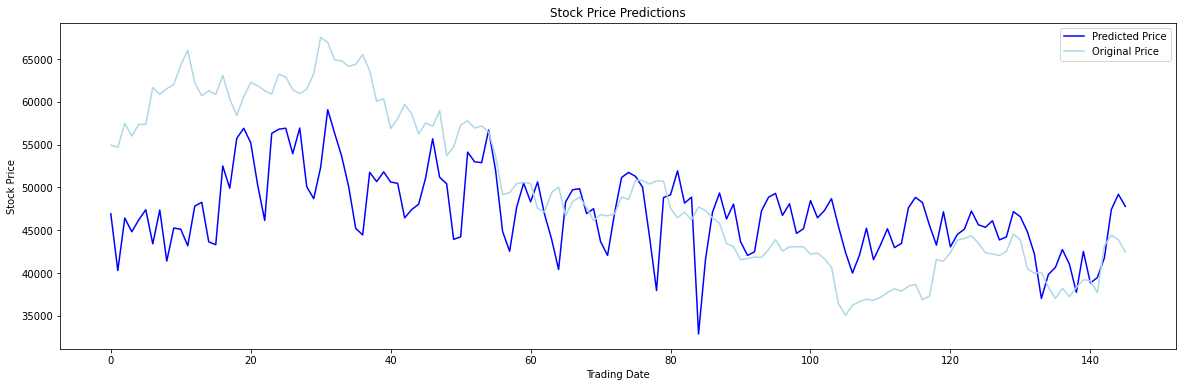

In [27]:
plt.plot(y_pred, color = 'blue', label = 'Predicted Price')
plt.plot(y_test, color = 'lightblue', label = 'Original Price')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()